In [252]:
%matplotlib inline
from fnmatch import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pattern
from pattern import web

from matplotlib import rcParams

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

In [253]:
import urllib2
import bs4

In [423]:
#code to get xml poll data from the RCP page
def get_poll_xml(url,poll_id):
    url = url+str(poll_id)+".xml"
    gcontext = ssl.SSLContext(ssl.PROTOCOL_TLSv1)
    print url
    
    request_line = urllib2.Request(url,headers={"User-Agent":"Magic Browser"})
    try:
        xml_source = urllib2.urlopen(request_line,context=gcontext)
        bs_tree = bs4.BeautifulSoup(xml_source)
    except urllib2.HTTPError, e:
        bs_tree = bs4.BeautifulSoup("<>")
    return bs_tree


    

In [255]:
#getting a dictionary with approve and disapprove crossponding to colors
def plot_colors(bs_tree):
    tag_got = bs_tree.find_all('graph')
    result = {}
    for i in range(len(tag_got)):
        result[tag_got[i]['title']] = tag_got[i]['color']
        result[tag_got[i]['title']] = tag_got[i]['color']
    return result

In [294]:
bs_tree = get_poll_xml("http://charts.realclearpolitics.com/charts/",1044)
plot_colors(bs_tree)

http://charts.realclearpolitics.com/charts/1044.xml


{'Approve': '#000000', 'Disapprove': '#FF0000'}

In [327]:
#converting the data from the chart to a data frame
def rcp_poll_data(bs_tree):
    color_dic = plot_colors(bs_tree)
    date_series = bs_tree.find_all('series')[0].find_all('value')
    date_list = [values.get_text() for values in date_series]
    poll_data_frame = pd.DataFrame({'date': pd.to_datetime(date_list)})
    
    #data_value = []
    i=0
    for graphs in (bs_tree.find_all('graph')):
        new_series = graphs.find_all('value')
        new_data = [float(values.get_text()) if values.get_text()!="" else np.nan  for values in new_series]
        #data_value.append(new_data)
        poll_data_frame[graphs['title']] = new_data
        i+=1
    
    
    
    return poll_data_frame
bs_tree = get_poll_xml("http://charts.realclearpolitics.com/charts/",1044)
frame_got = rcp_poll_data(bs_tree)
frame_got.tail()
    



http://charts.realclearpolitics.com/charts/1044.xml


,date,Approve,Disapprove
1826,2014-01-27,NaN,NaN
1827,2014-01-28,NaN,NaN
1828,2014-01-29,NaN,NaN
1829,2014-01-30,NaN,NaN
1830,2014-01-31,NaN,NaN


http://charts.realclearpolitics.com/charts/1044.xml


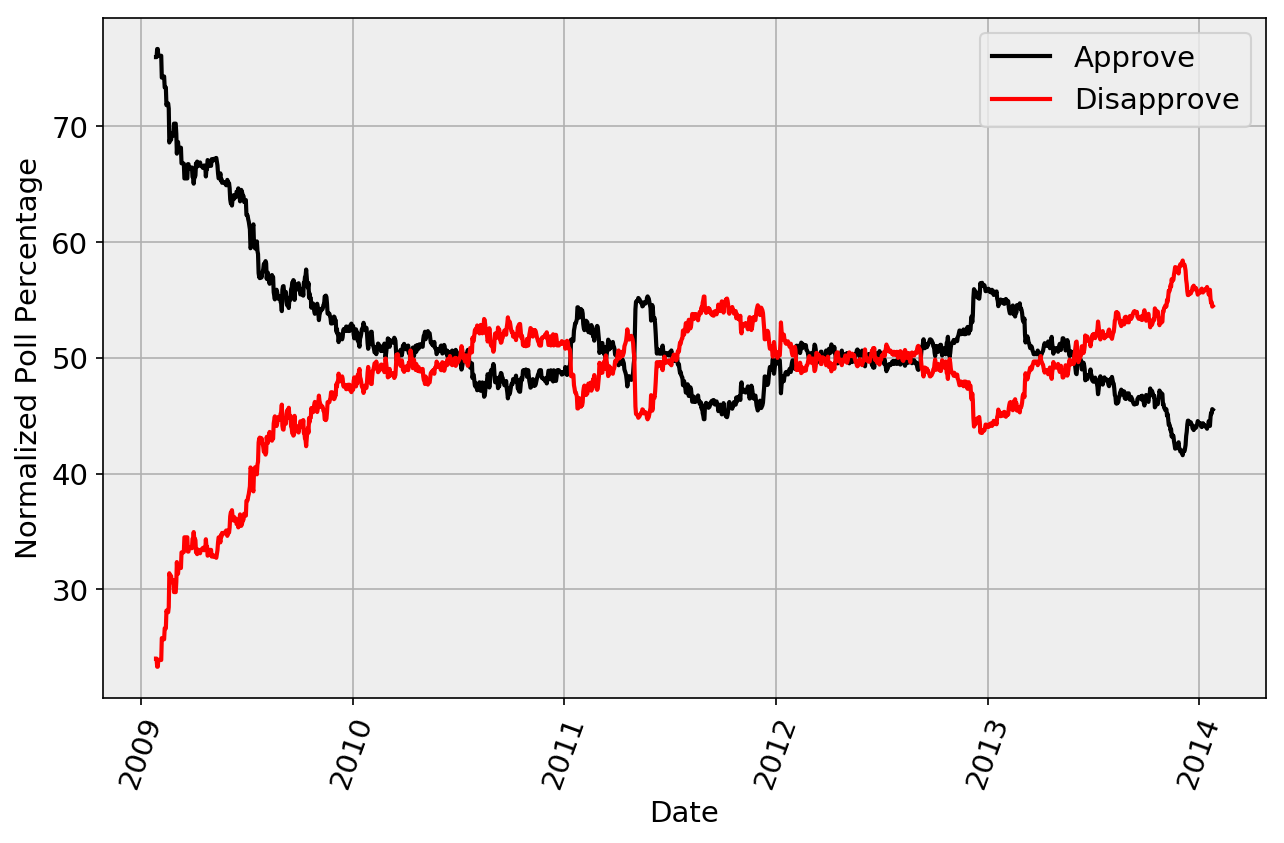

In [312]:
def poll_plot(link,poll_id):
    bs_tree = get_poll_xml(link,poll_id)
    color_dic = plot_colors(bs_tree)
    poll_data = rcp_poll_data(bs_tree)
    norm =  poll_data[color_dic.keys()].sum(axis=1)/100
    for c in color_dic.keys():
        poll_data[c] =  poll_data[c]/norm
    for label,color in color_dic.items():
        plt.plot(poll_data['date'],poll_data[label],color = color, label = label)
    
    plt.xticks(rotation=70)
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Normalized Poll Percentage")
    
    
poll_plot("http://charts.realclearpolitics.com/charts/",1044)
    

In [267]:
#getting links to previous governor races page
def find_governor_races(url):
    gcontext = ssl.SSLContext(ssl.PROTOCOL_TLSv1)
    request =  urllib2.Request(url,headers={"User-Agent":"Ting"})
    html = urllib2.urlopen(request,context=gcontext)
    bs_tree = bs4.BeautifulSoup(html)
    tags = bs_tree.find_all('a')
    result = []
    for tag in tags:
        if tag.get('href'):
            if fnmatch(tag['href'],'/epolls/2010/governor/*/*'):
                result.append(tag['href'])
                
    return result


In [264]:
import ssl

In [298]:
def get_actual_election_results(link):
    gcontext = ssl.SSLContext(ssl.PROTOCOL_TLSv1)
    print "https://www.realclearpolitics.com"+link
    request = urllib2.Request("https://www.realclearpolitics.com"+link,headers={"User-Agent":"ting"})
    html = urllib2.urlopen(request,context=gcontext)
    bs_tree = bs4.BeautifulSoup(html)
    tags = bs_tree.find_all('tr')
    result = {}
    i = 1
    tot_sum = 0.0
    for rows in tags[0].find_all('th'):
        nameGot = rows.get_text()
        #print nameGot
        if nameGot == "Spread":
            break
        elif i>=4:
            candidate = nameGot
            percent = tags[1].find_all('td')[i-1].get_text()
            #print percent
            result[candidate] = float(percent)
            tot_sum+=result[candidate]
            print tot_sum
        i+=1
    tot_sum/=100
    for candidates in result.keys():
        result[candidates] = result[candidates]/tot_sum
        
    return result






In [372]:
link_list = find_governor_races("http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html")
election_result  = [get_actual_election_results(link) for link in link_list]    

https://www.realclearpolitics.com/epolls/2010/governor/ar/arkansas_governor_keet_vs_beebe-1568.html
64.5
98.1
https://www.realclearpolitics.com/epolls/2010/governor/md/maryland_governor_ehrlich_vs_omalley-1121.html
42.3
98.1
https://www.realclearpolitics.com/epolls/2010/governor/ny/new_york_governor_paladino_vs_cuomo-1423.html
61.4
95.5
https://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html


KeyboardInterrupt: 

In [196]:
election_result

[{u'Beebe (D)': 64.5, u'Keet (R)': 33.6},
 {u'Ehrlich (R)': 42.3, u"O'Malley (D)": 55.8},
 {u'Cuomo (D)': 61.4, u'Paladino (R)': 34.1},
 {u'Brown (D)': 53.1, u'Whitman (R)': 41.7},
 {u'Lynch (D)': 52.6, u'Stephen (R)': 45.1},
 {u'Hickenlooper (D)': 50.7, u'Maes (R)': 11.1, u'Tancredo ': 36.8},
 {u'Foley (R)': 48.9, u'Malloy (D)': 49.6},
 {u'Scott (R)': 48.9, u'Sink (D)': 47.7},
 {u'Abercrombie (D)': 58.2, u'Aiona (R)': 41.1},
 {u'Brady (R)': 46.1, u'Quinn (D)': 46.6},
 {u'Baker (R)': 42.1, u'Cahill (I)': 8.0, u'Patrick (D)': 48.4},
 {u'Dayton (D)': 43.7, u'Emmer (R)': 43.2, u'Horner (I)': 11.9},
 {u'Kasich (R)': 49.4, u'Strickland (D)': 46.7},
 {u'Dudley (R)': 48.1, u'Kitzhaber (D)': 49.2},
 {u'Caprio (D)': 23.0, u'Chafee (I)': 36.1, u'Robitaille (R)': 33.6},
 {u'Dubie (R)': 47.8, u'Shumlin (D)': 49.6},
 {u'Brewer (R)': 54.7, u'Goddard (D)': 42.2},
 {u'Barnes (D)': 43.1, u'Deal (R)': 52.9},
 {u'Denish (D)': 46.4, u'Martinez (R)': 53.6},
 {u'Corbett (R)': 54.5, u'Onorato (D)': 45.5},
 {

In [272]:
def id_from_url(url):
    return url.split('-')[-1].split('.html')[0]

def plot_race(url):
    print url
    id = id_from_url(url)
    main_url = "http://charts.realclearpolitics.com/charts/"
    bs_tree = get_poll_xml(main_url,id)
    colors = plot_colors(bs_tree)
    print colors
    if len(colors) == 0:
        return
   
             
    result = get_actual_election_results(url)
    
    poll_plot(main_url,id)
    plt.xlabel("Date")
    plt.ylabel("Polling Percentage")
    for r in result:
        #print r[:-4]
        if r.strip() == "Tancredo":
            r=r.strip()
            #plt.axhline(result[r],color = colors[r[:]],alpha = 0.6 ,ls = "--")
        else:
            plt.axhline(result[r],color = colors[r[:-4]],alpha = 0.6 ,ls = "--")


































/epolls/2010/governor/ar/arkansas_governor_keet_vs_beebe-1568.html
{'Beebe': '#3B5998', 'Keet': '#D30015'}
64.5
98.1


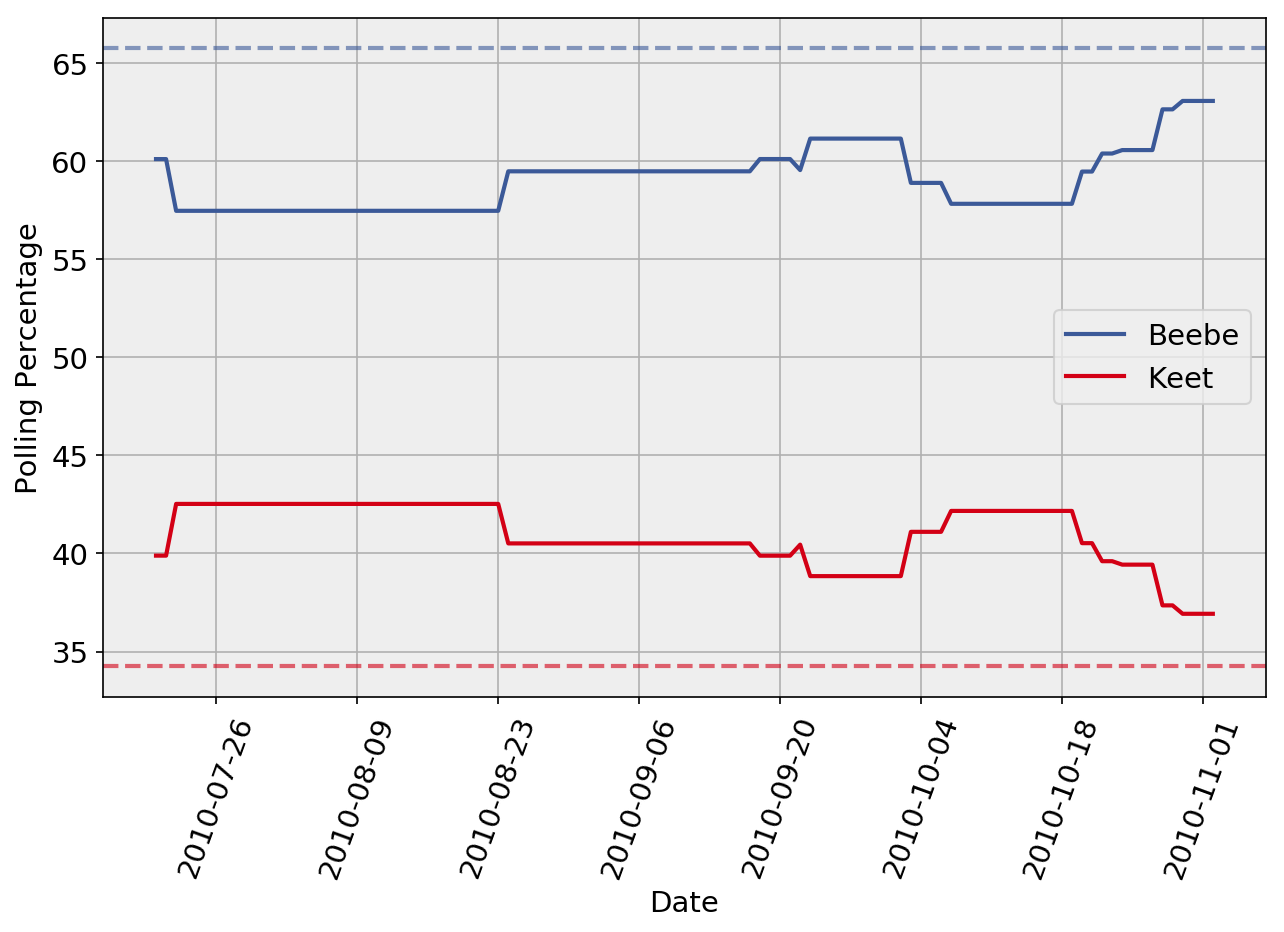

/epolls/2010/governor/ny/new_york_governor_paladino_vs_cuomo-1423.html
{'Paladino': '#D30015', 'Cuomo': '#3B5998'}
61.4
95.5


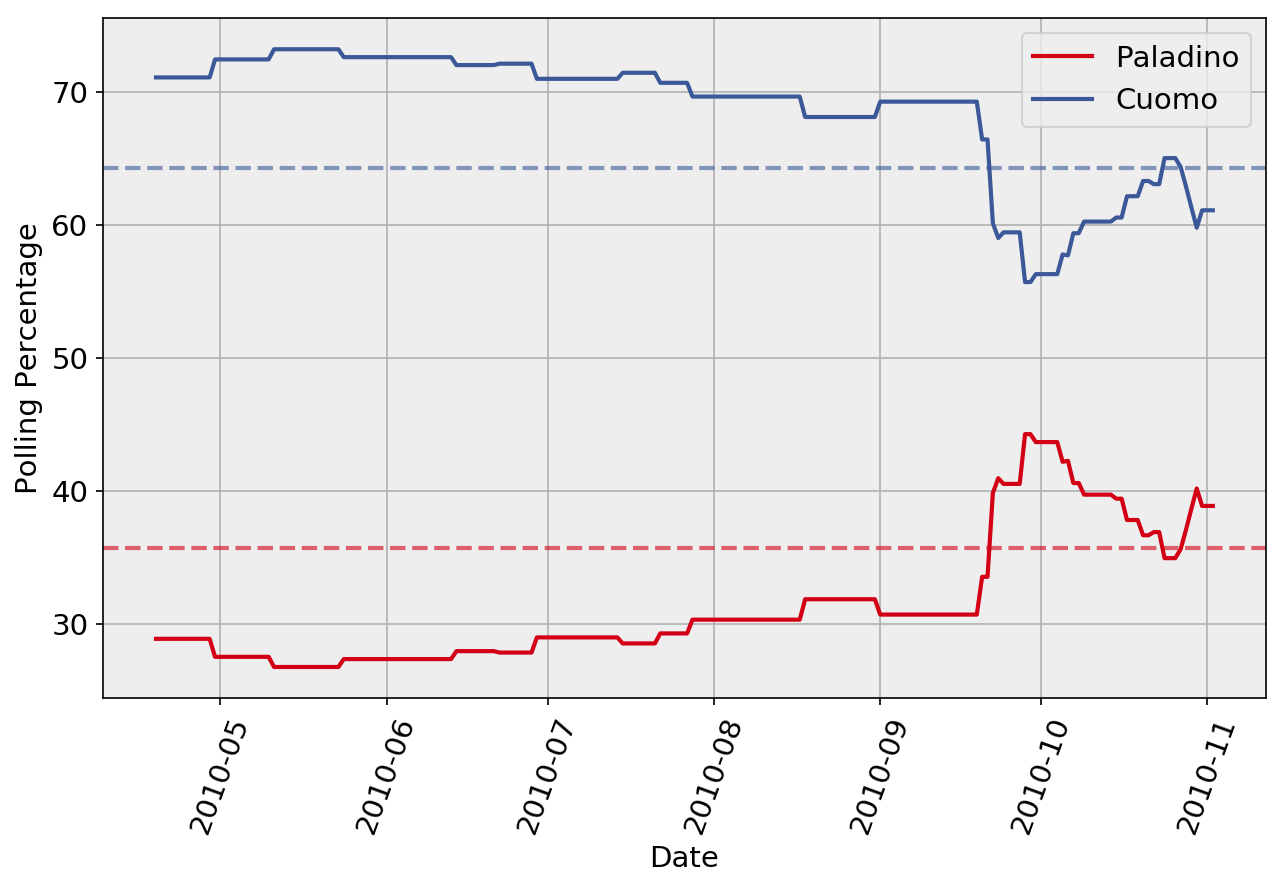

/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html
{'Brown': '#3B5998', 'Whitman': '#D30015'}
53.1
94.8


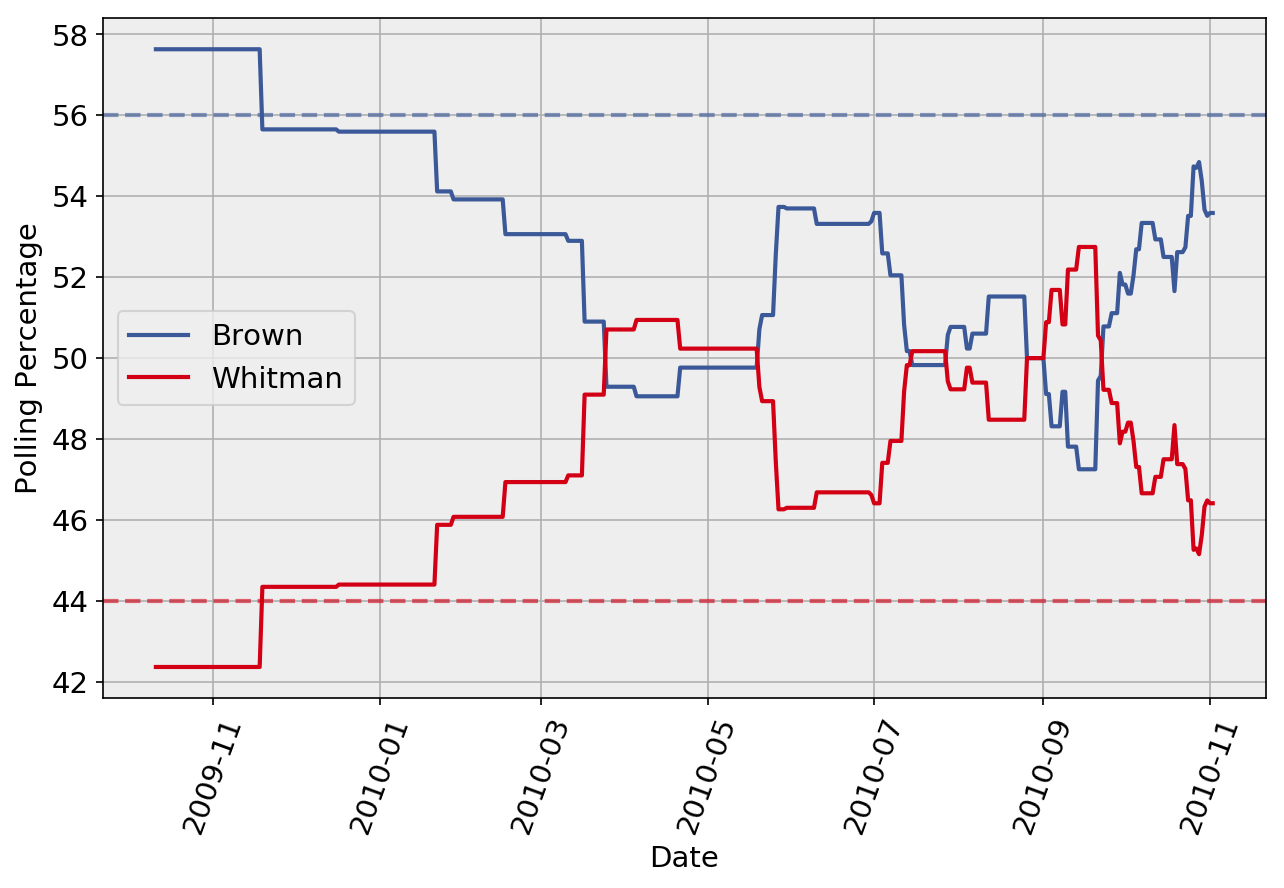

/epolls/2010/governor/nh/new_hampshire_governor_stephen_vs_lynch-1446.html
{'Stephen': '#D30015', 'Lynch': '#3B5998'}
52.6
97.7


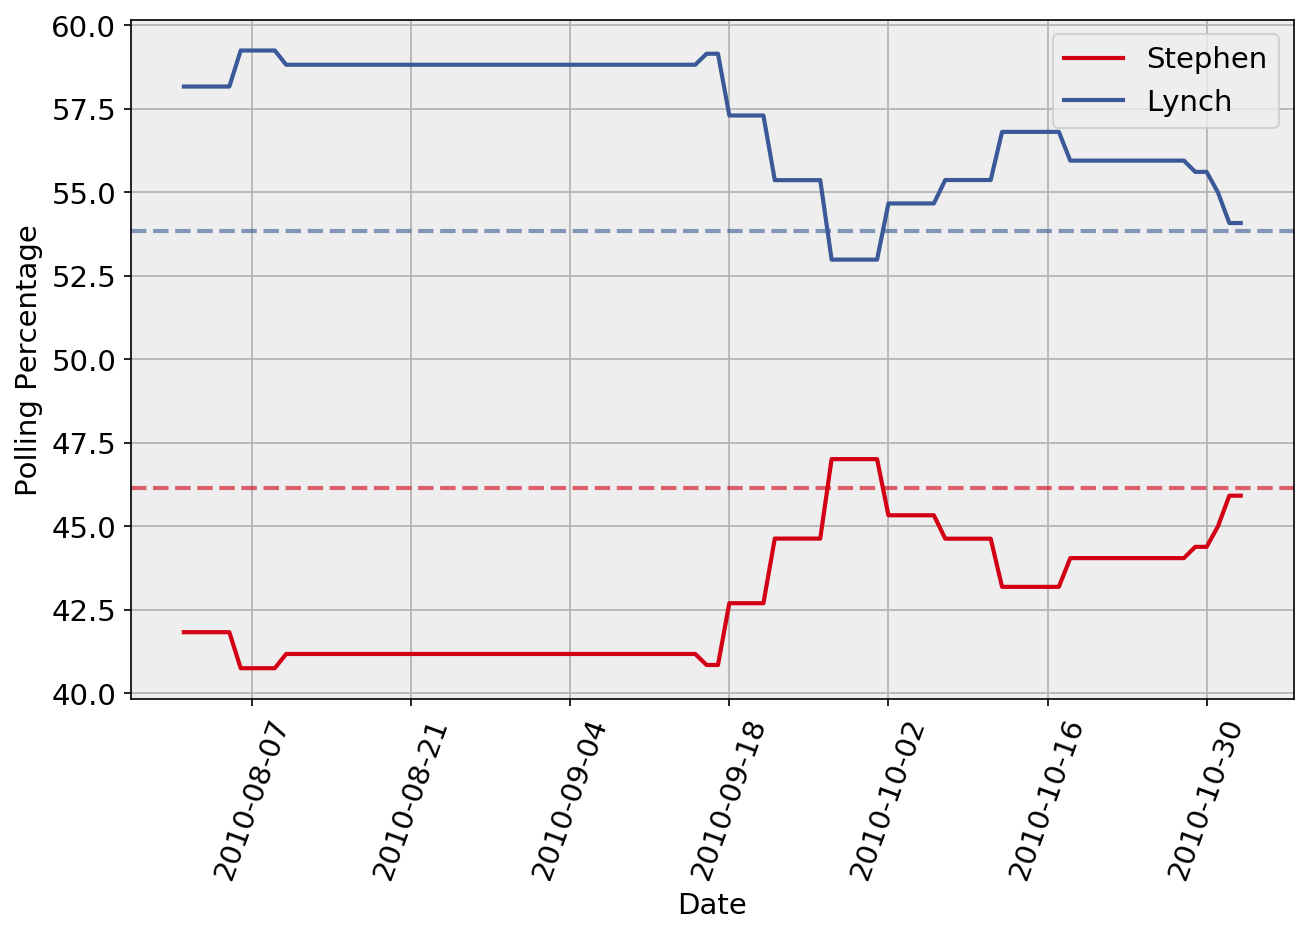

/epolls/2010/governor/co/colorado_governor_maes_vs_hickenlooper_vs_tancredo-1677.html
{'Tancredo': '#990000', 'Maes': '#D30015', 'Hickenlooper': '#3B5998'}
50.7
61.8
98.6


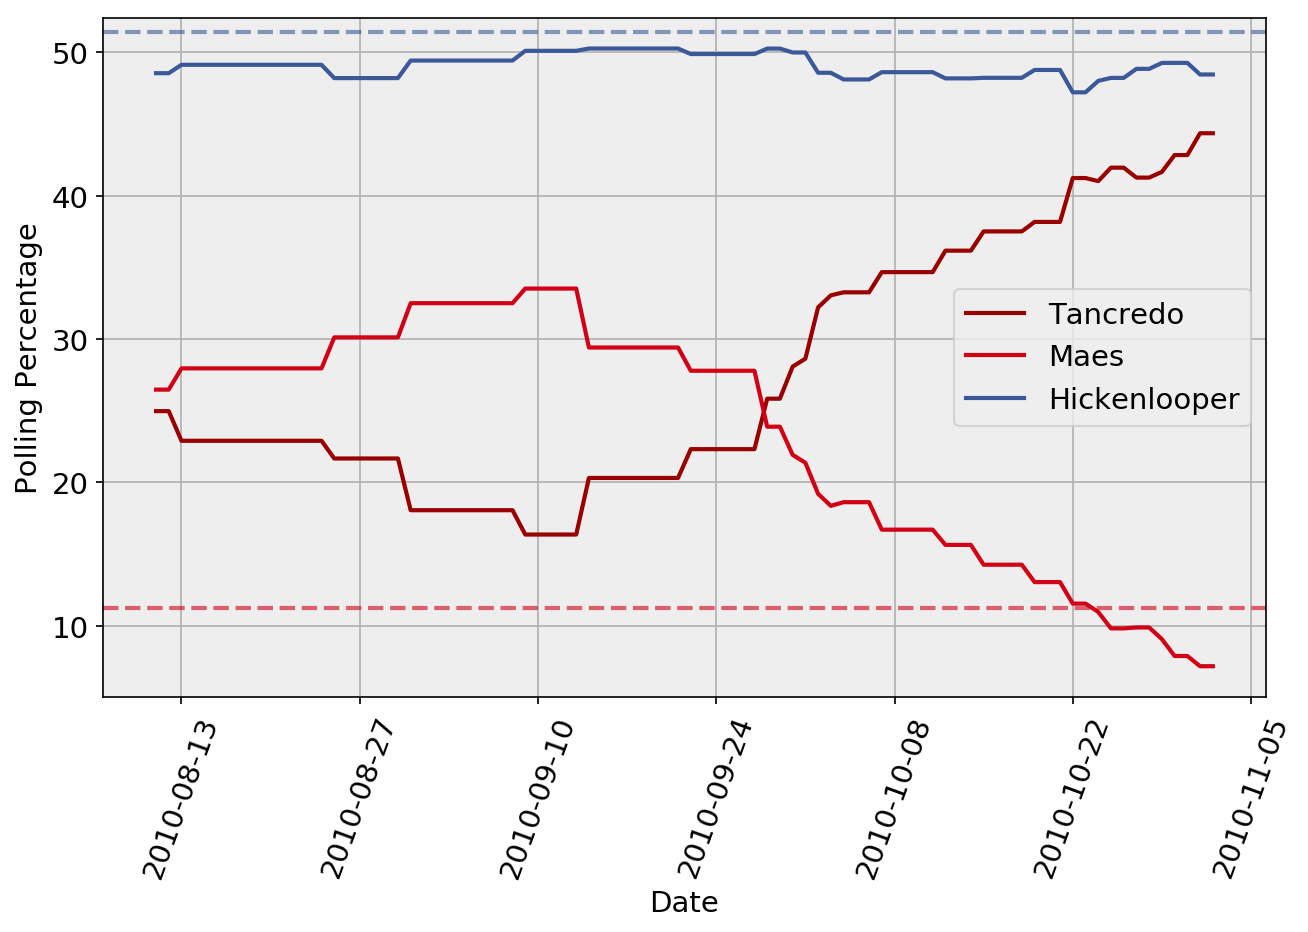

/epolls/2010/governor/ct/connecticut_governor_foley_vs_malloy-1357.html
{'Foley': '#D30015', 'Malloy': '#3B5998'}
48.9
98.5


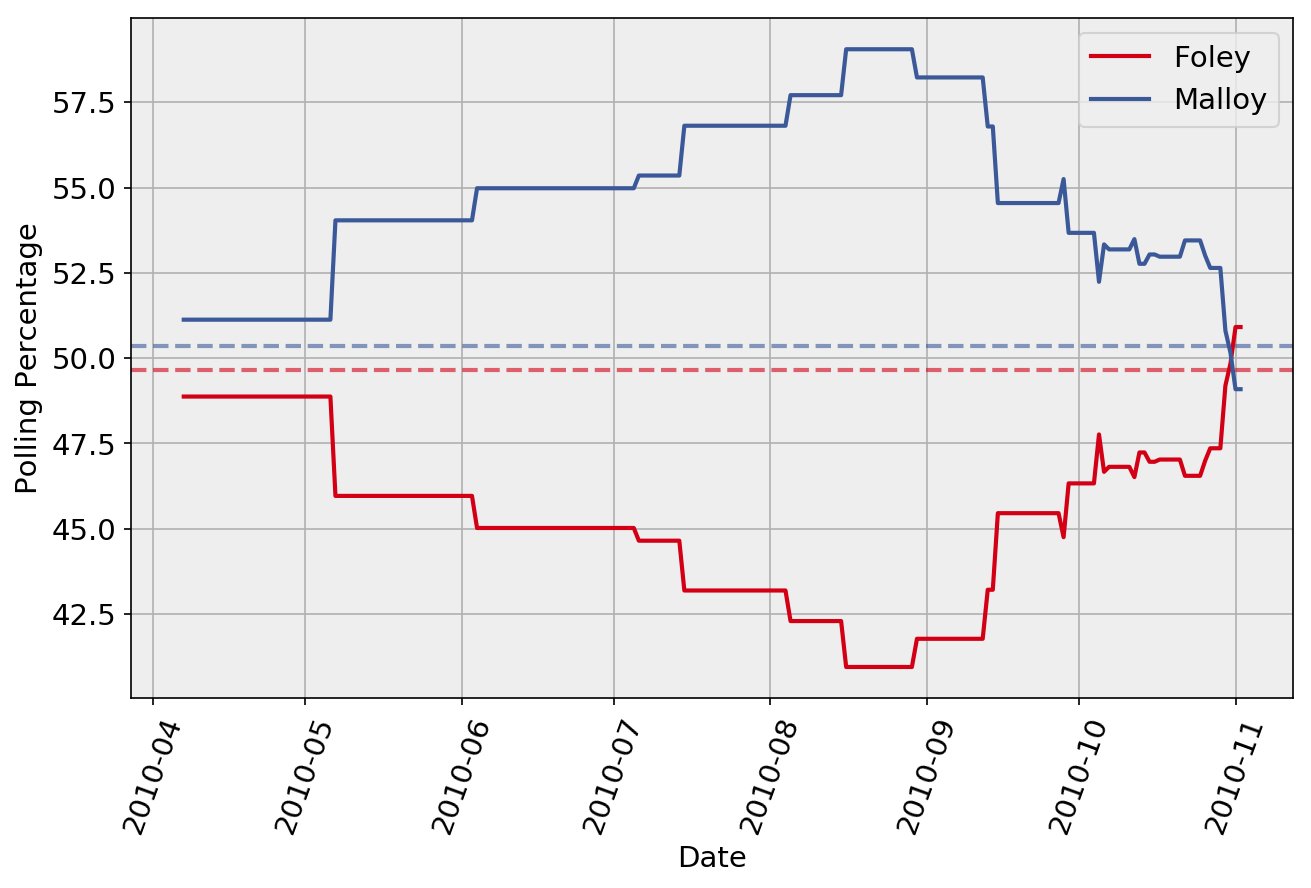

/epolls/2010/governor/fl/florida_governor_scott_vs_sink_vs_chiles-1607.html
{'Scott': '#D30015', 'Sink': '#3B5998'}
48.9
96.6


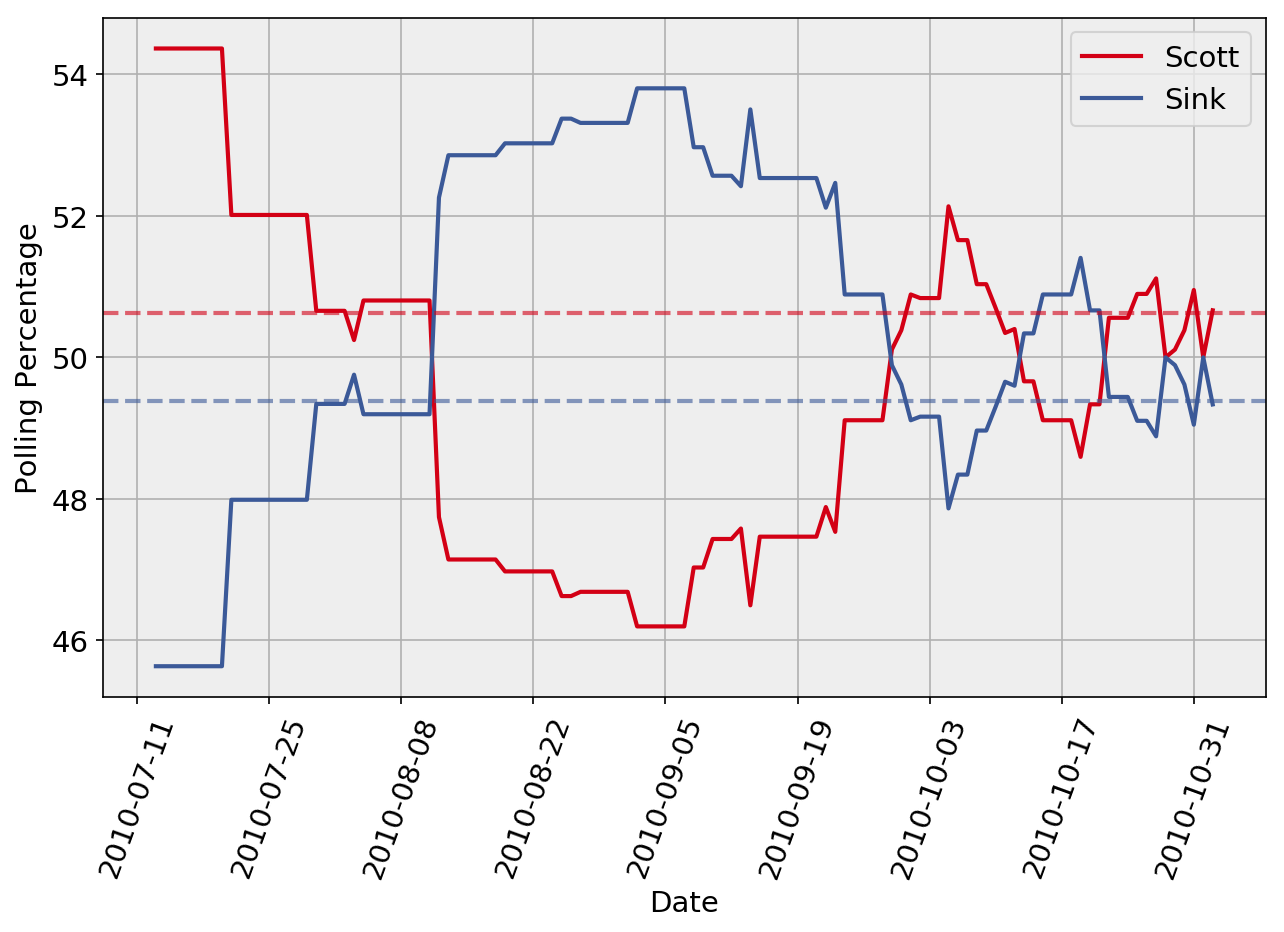

/epolls/2010/governor/hi/hawaii_governor_aiona_vs_abercrombie-1163.html
{}
/epolls/2010/governor/il/illinois_governor_brady_vs_quinn-1361.html
{'Brady': '#D30015', 'Quinn': '#3B5998'}
46.1
92.7


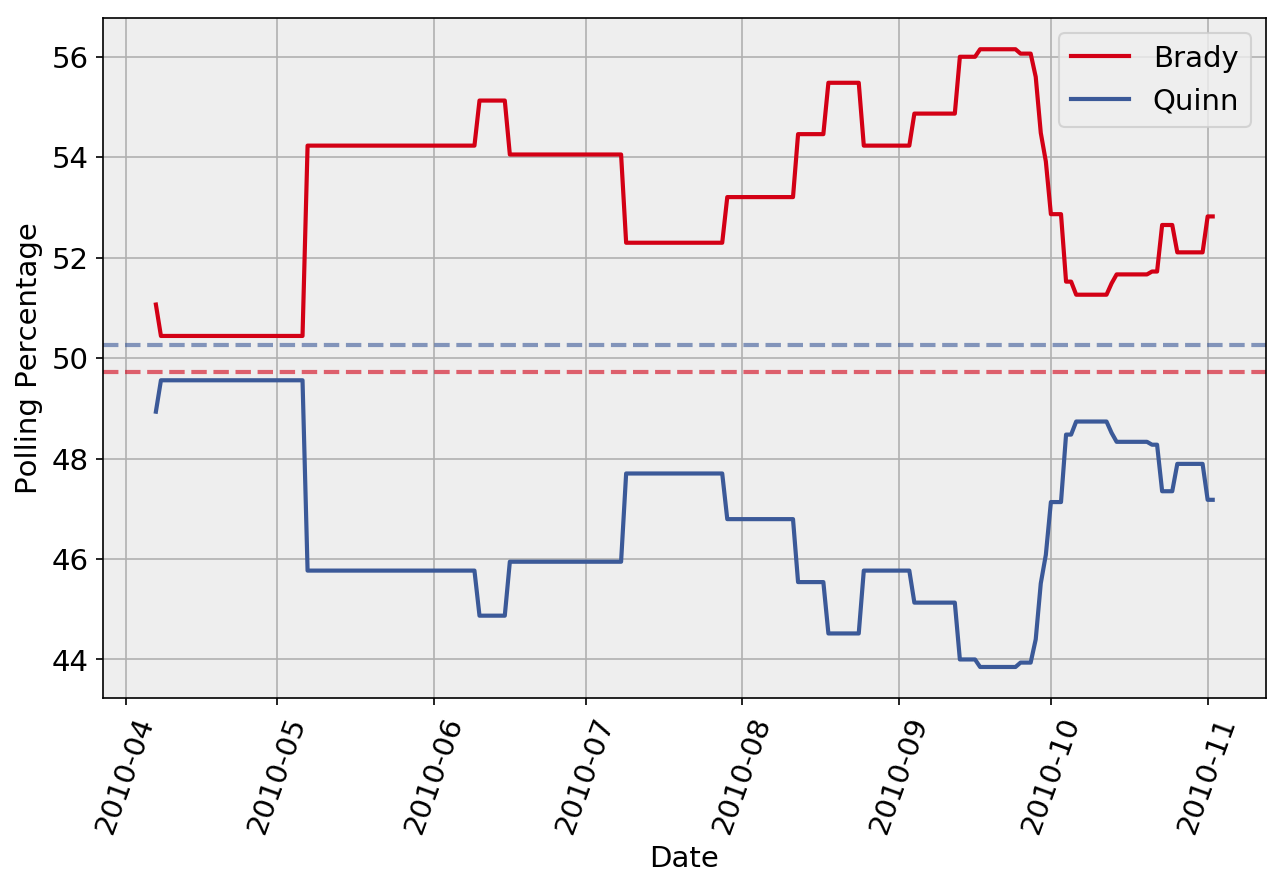

/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html
{'Patrick': '#3B5998', 'Baker': '#D30015', 'Cahill': '#000000'}
42.1
50.1
98.5


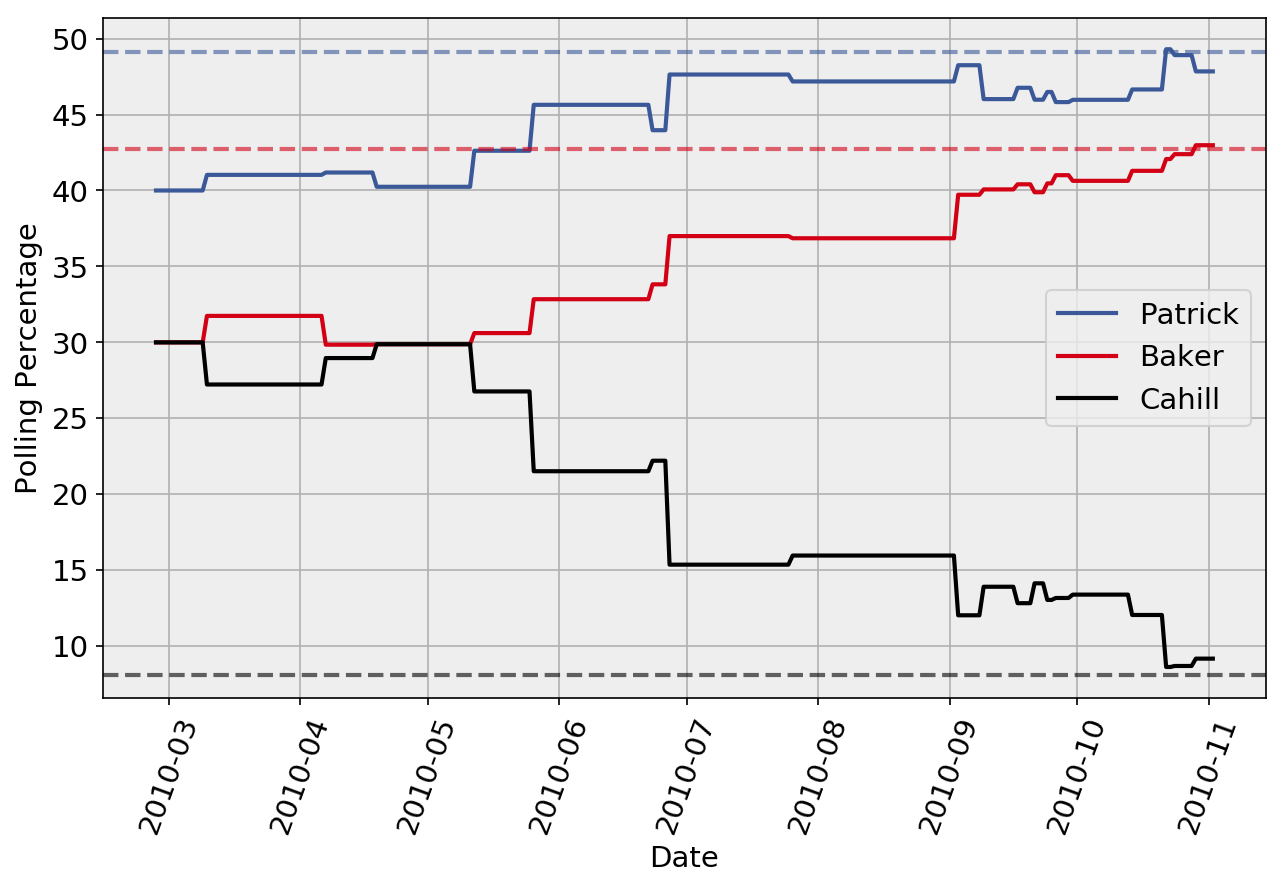

/epolls/2010/governor/mn/minnesota_governor_emmer_vs_dayton_vs_horner-1393.html
{'Horner': '#000000', 'Emmer': '#D30015', 'Dayton': '#3B5998'}
43.7
86.9
98.8


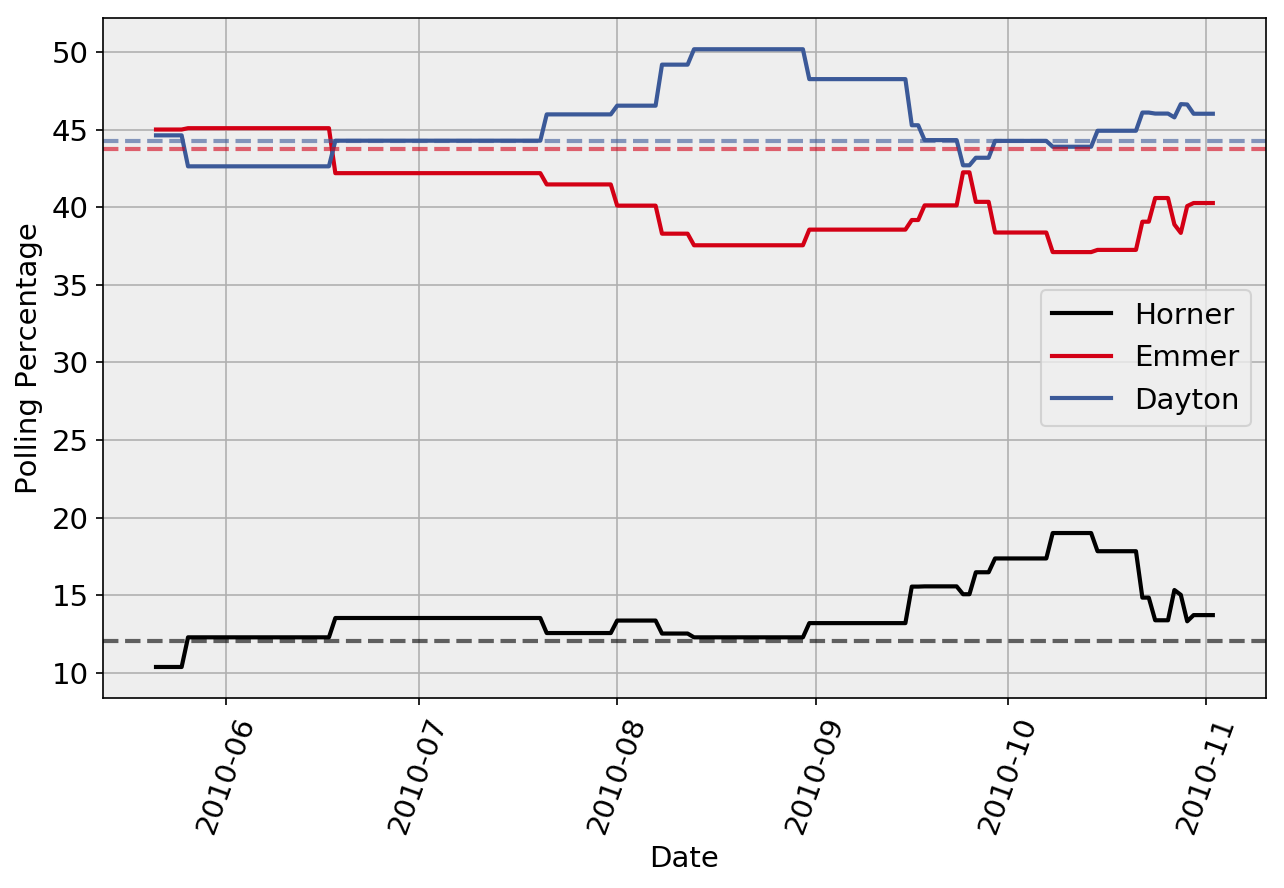

/epolls/2010/governor/oh/ohio_governor_kasich_vs_strickland-1078.html
{'Strickland': '#3B5998', 'Kasich': '#D30015'}
49.4
96.1


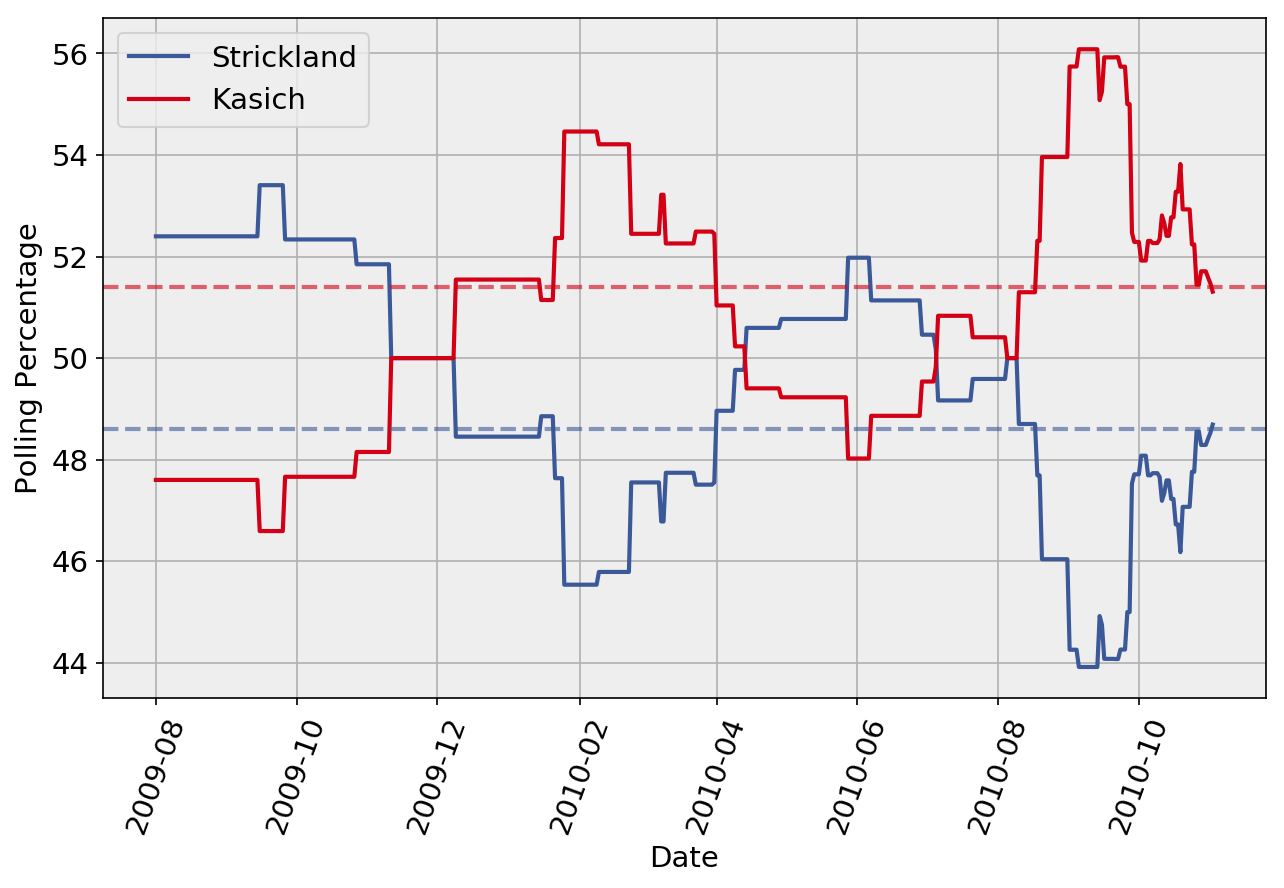

/epolls/2010/governor/or/oregon_governor_dudley_vs_kitzhaber-1088.html
{'Kitzhaber': '#3B5998', 'Dudley': '#D30015'}
48.1
97.3


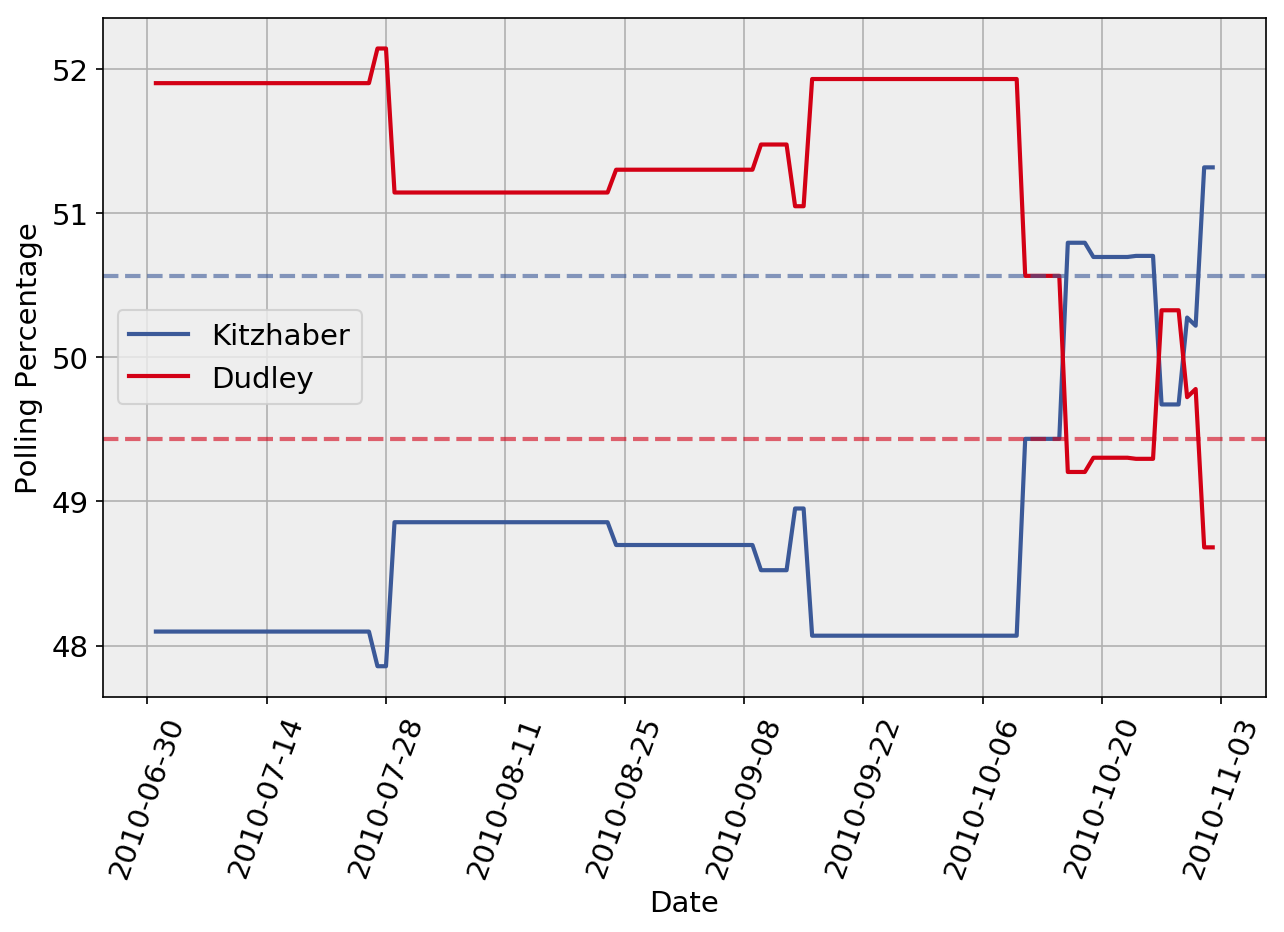

/epolls/2010/governor/ri/rhode_island_governor_chafee_vs_caprio_vs_robitaille-1232.html
{'Caprio': '#3B5998', 'Robitaille': '#D30015', 'Chafee': '#009900'}
23.0
59.1
92.7


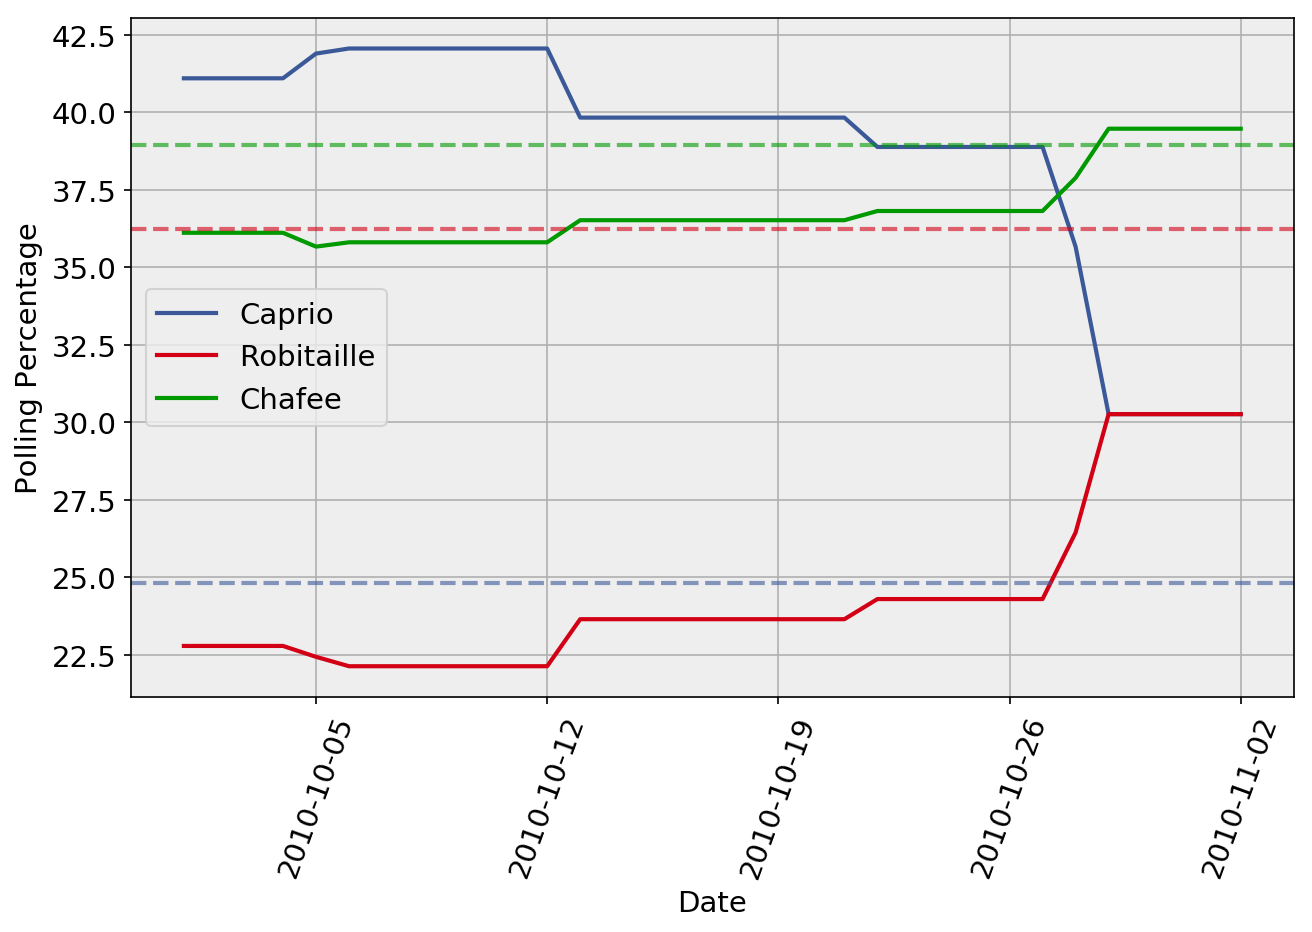

/epolls/2010/governor/vt/vermont_governor_dubie_vs_shumlin-1228.html
{}
/epolls/2010/governor/az/arizona_governor_brewer_vs_goddard-1409.html
{'Goddard': '#3B5998', 'Brewer': '#D30015'}
54.7
96.9


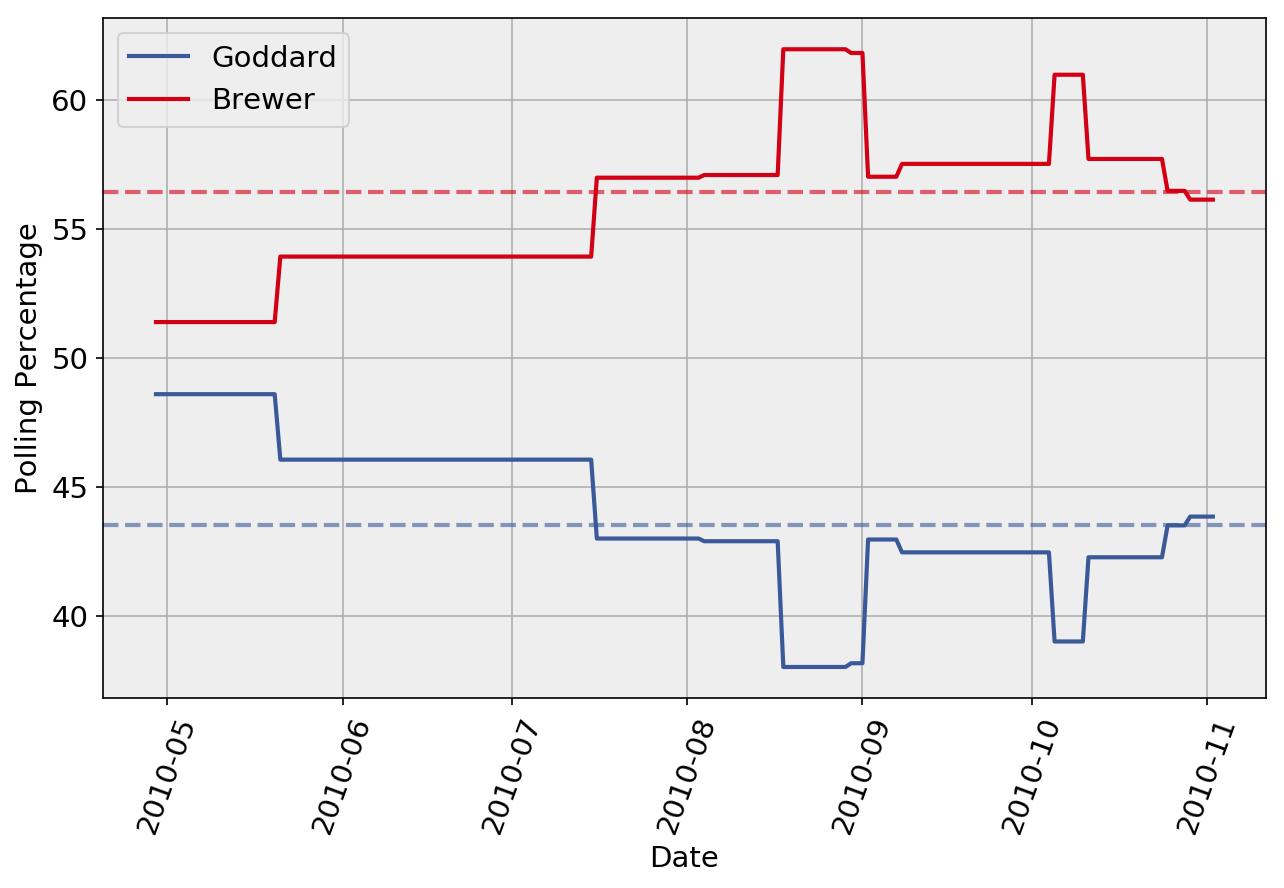

/epolls/2010/governor/ga/georgia_governor_deal_vs_barnes-1316.html
{'Barnes': '#3B5998', 'Deal': '#D30015'}
43.1
96.0


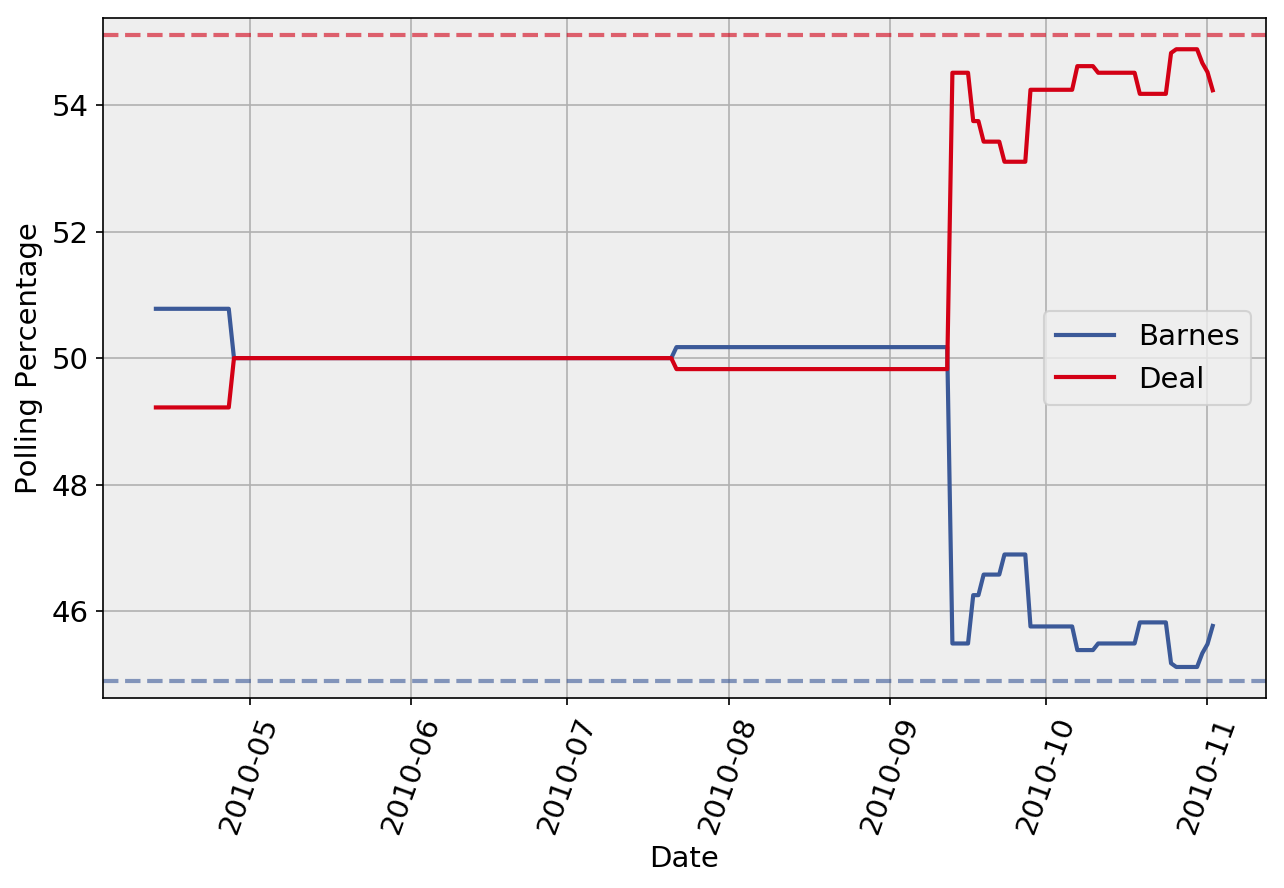

/epolls/2010/governor/nm/new_mexico_governor_martinez_vs_denish-1323.html
{'Martinez': '#D30015', 'Denish': '#3B5998'}
46.4
100.0


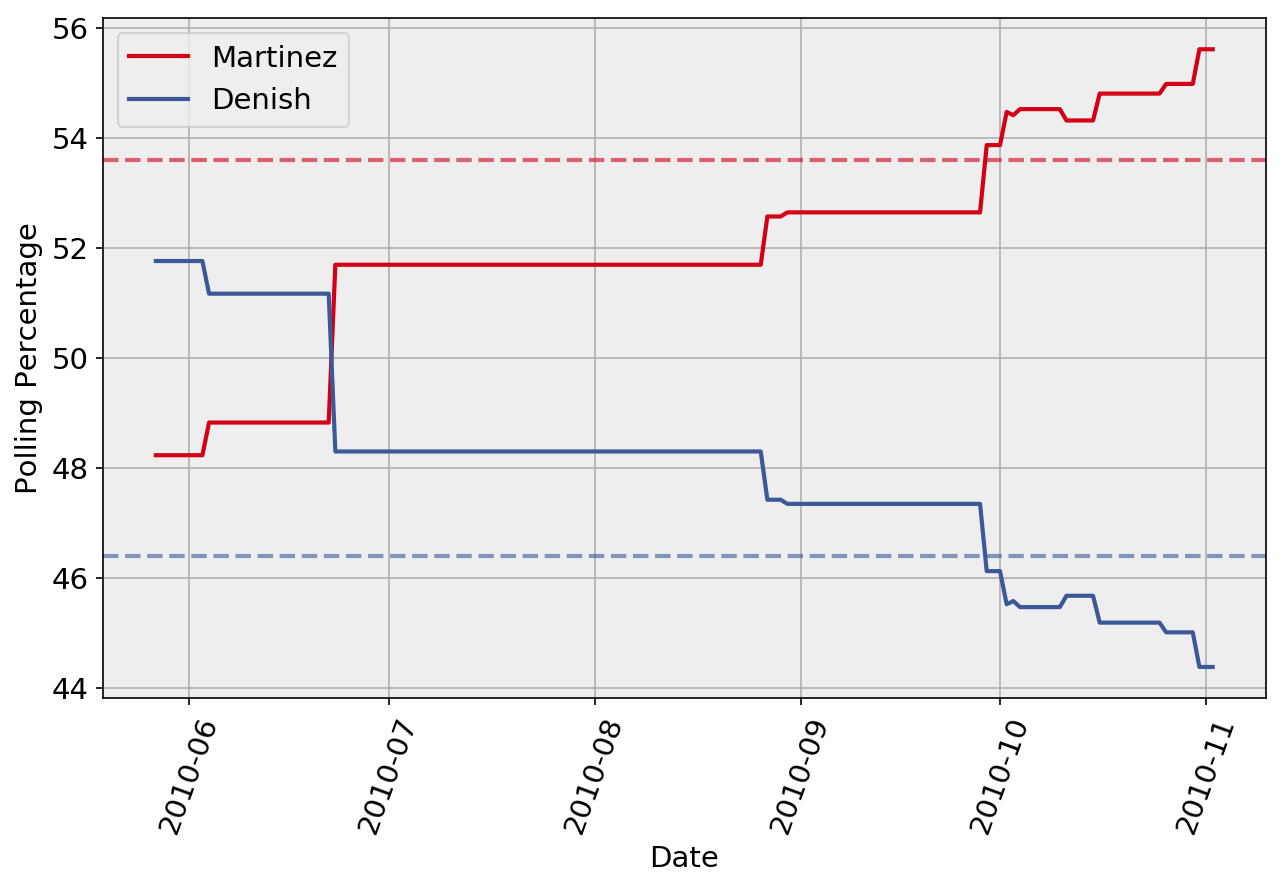

/epolls/2010/governor/pa/pennsylvania_governor_corbett_vs_onorato-1333.html
{'Corbett': '#D30015', 'Onorato': '#3B5998'}
54.5
100.0


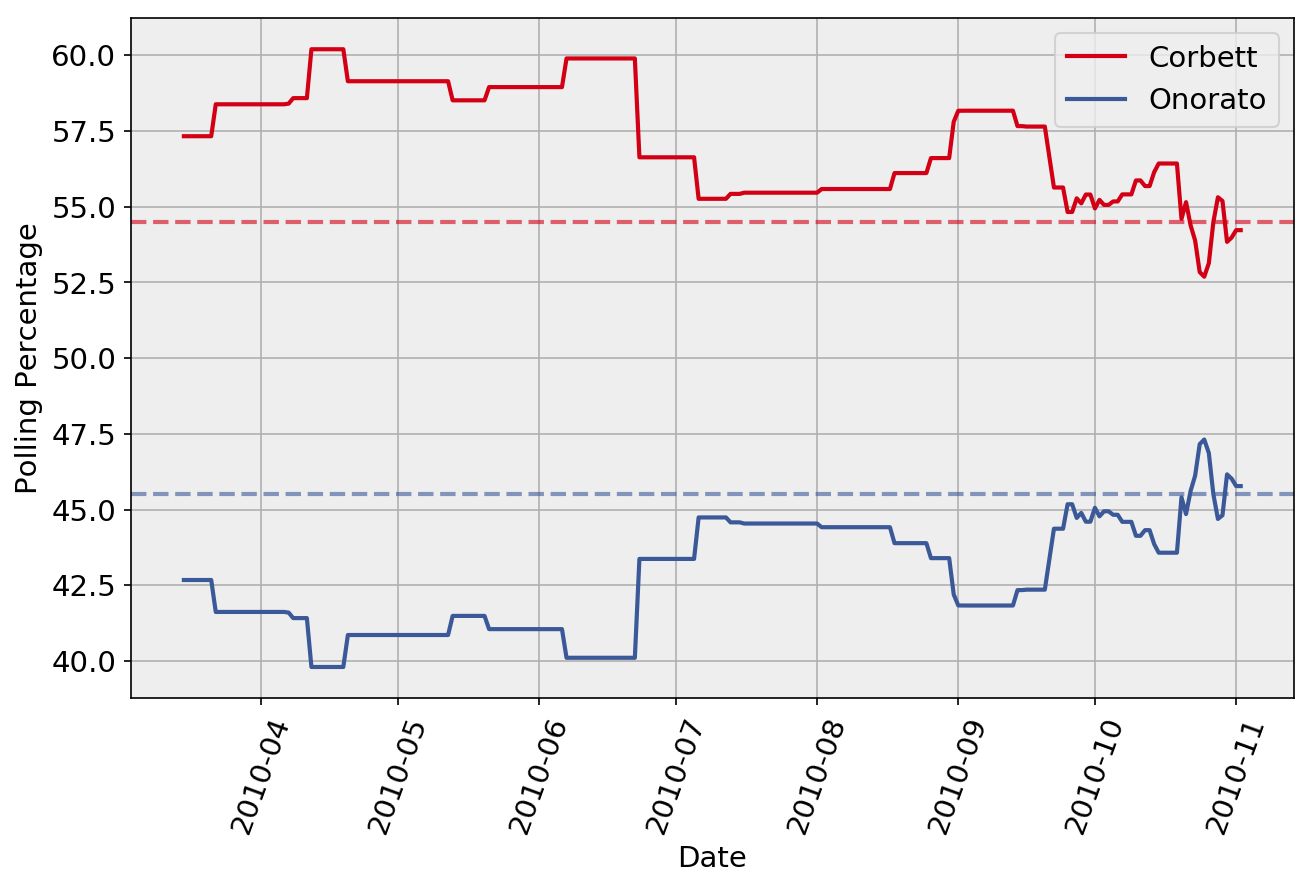

/epolls/2010/governor/sc/south_carolina_governor_haley_vs_sheheen-1574.html
{'Haley': '#D30015', 'Sheheen': '#3B5998'}
51.4
98.5


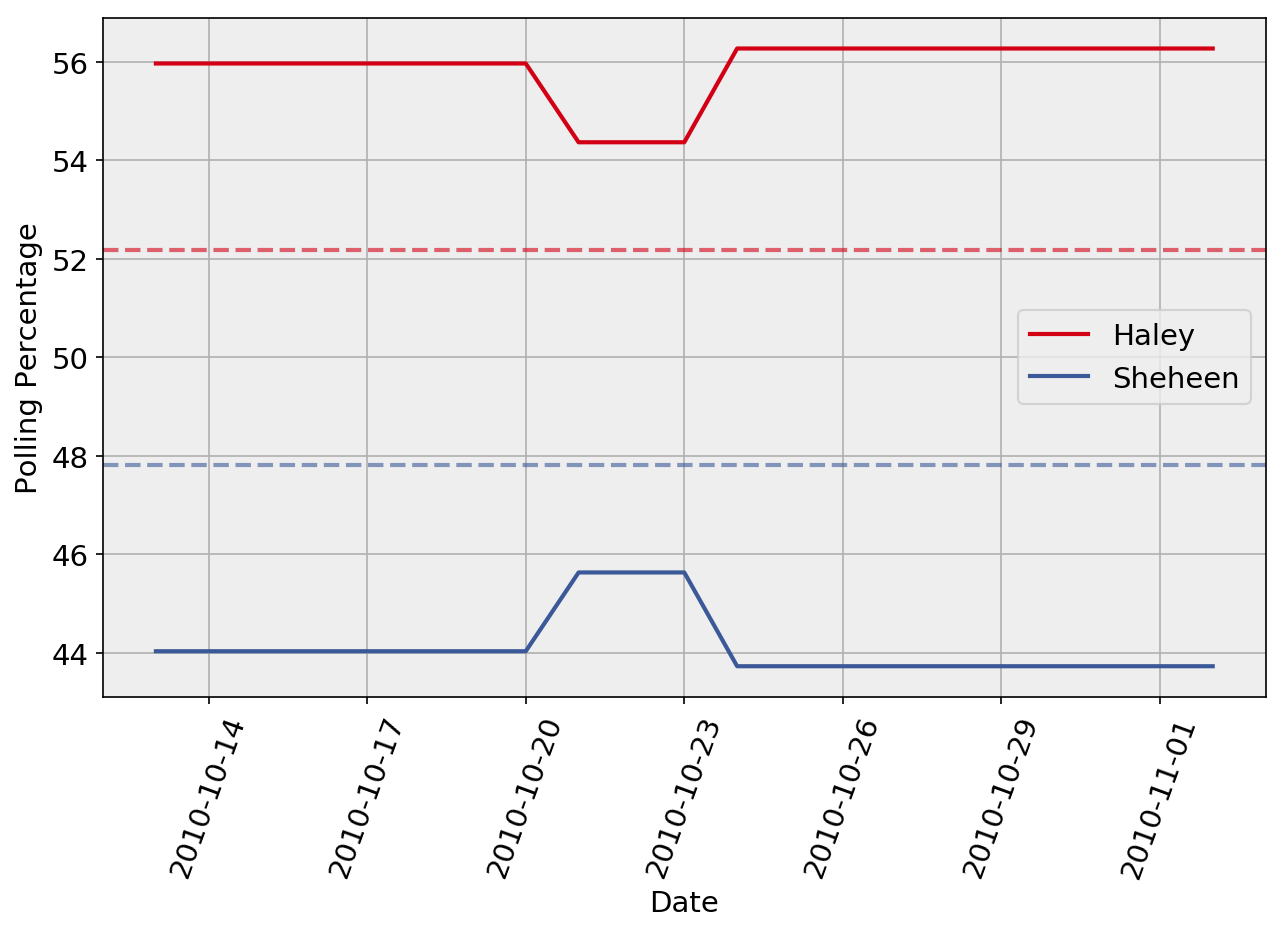

/epolls/2010/governor/tx/texas_governor_perry_vs_white-1194.html
{'White': '#3B5998', 'Perry': '#D30015'}
55.1
97.4


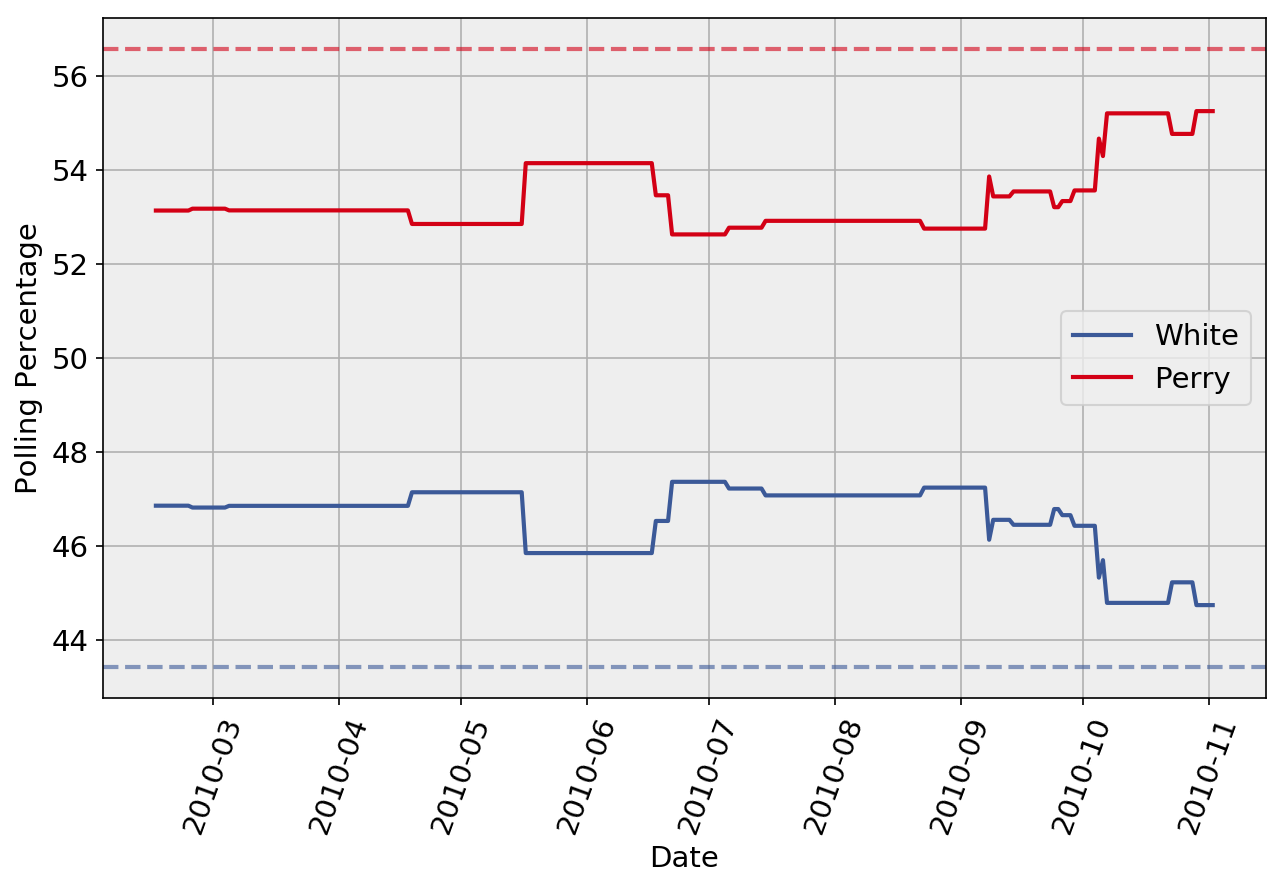

/epolls/2010/governor/wi/wisconsin_governor_walker_vs_barrett-1184.html
{'Walker': '#D30015', 'Barrett': '#3B5998'}
46.6
98.9


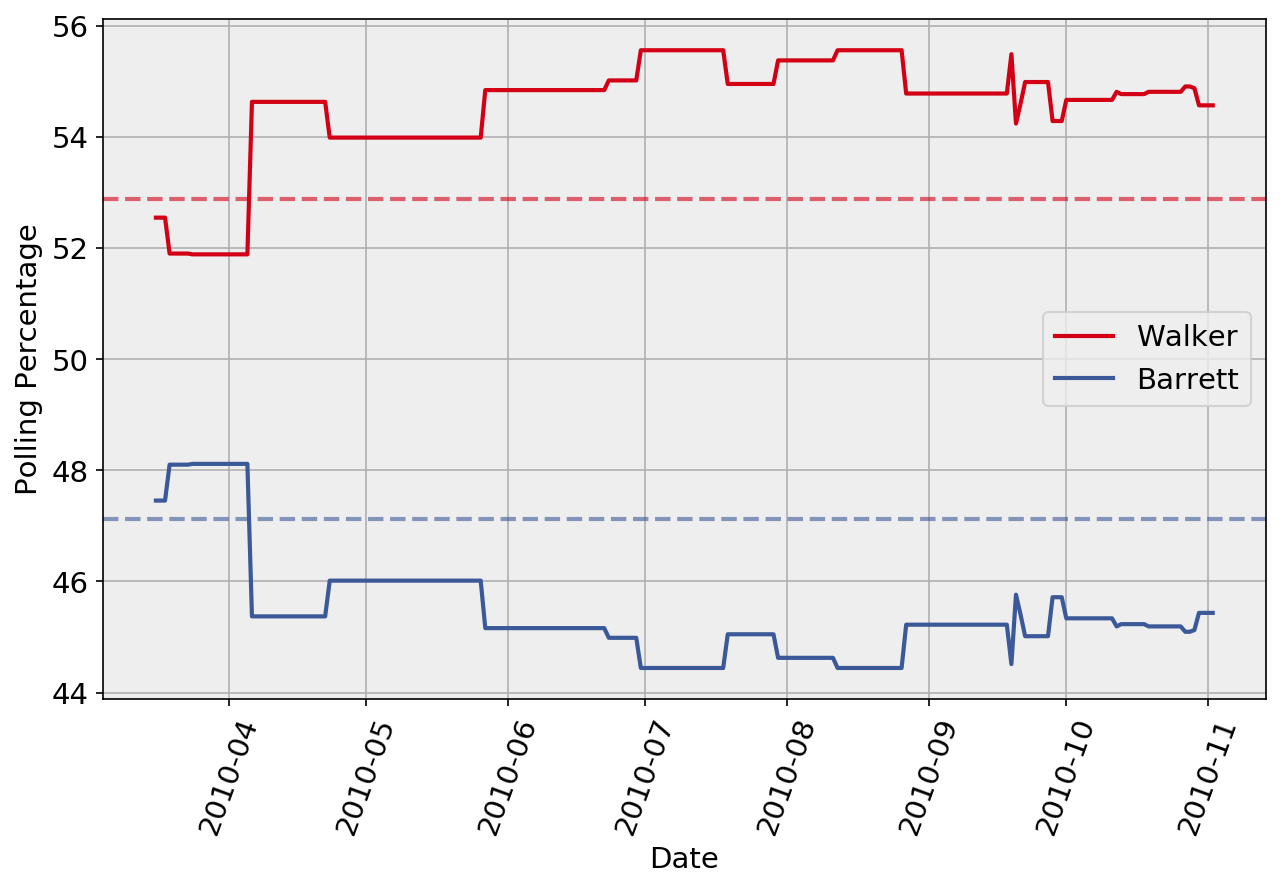

/epolls/2010/governor/ak/alaska_governor_parnell_vs_berkowitz-1510.html
{'Berkowitz': '#3B5998', 'Parnell': '#D30015'}
38.3
97.2


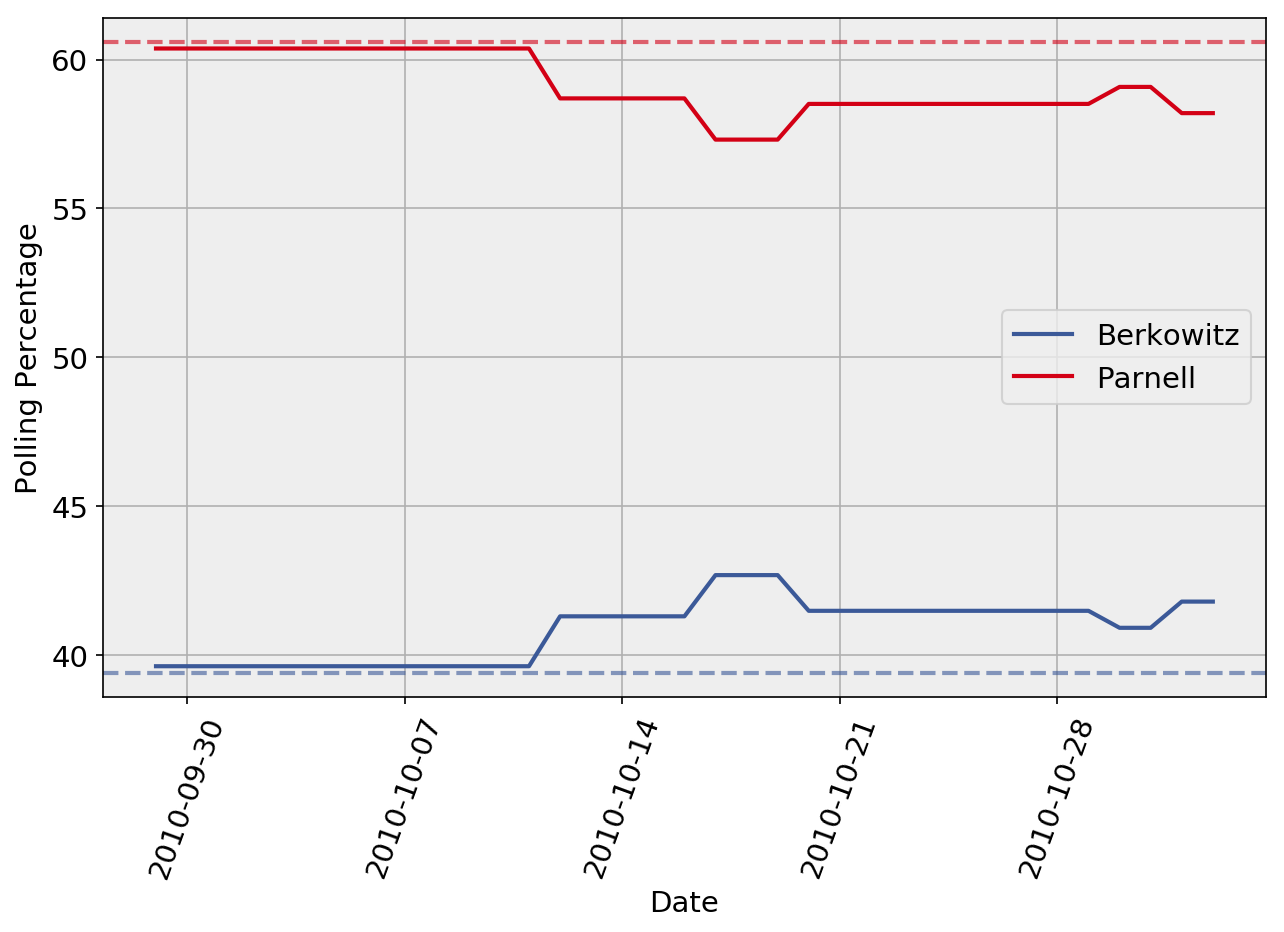

/epolls/2010/governor/ia/iowa_governor_branstad_vs_culver-1200.html
{'Culver': '#3B5998', 'Branstad': '#D30015'}
53.0
96.3


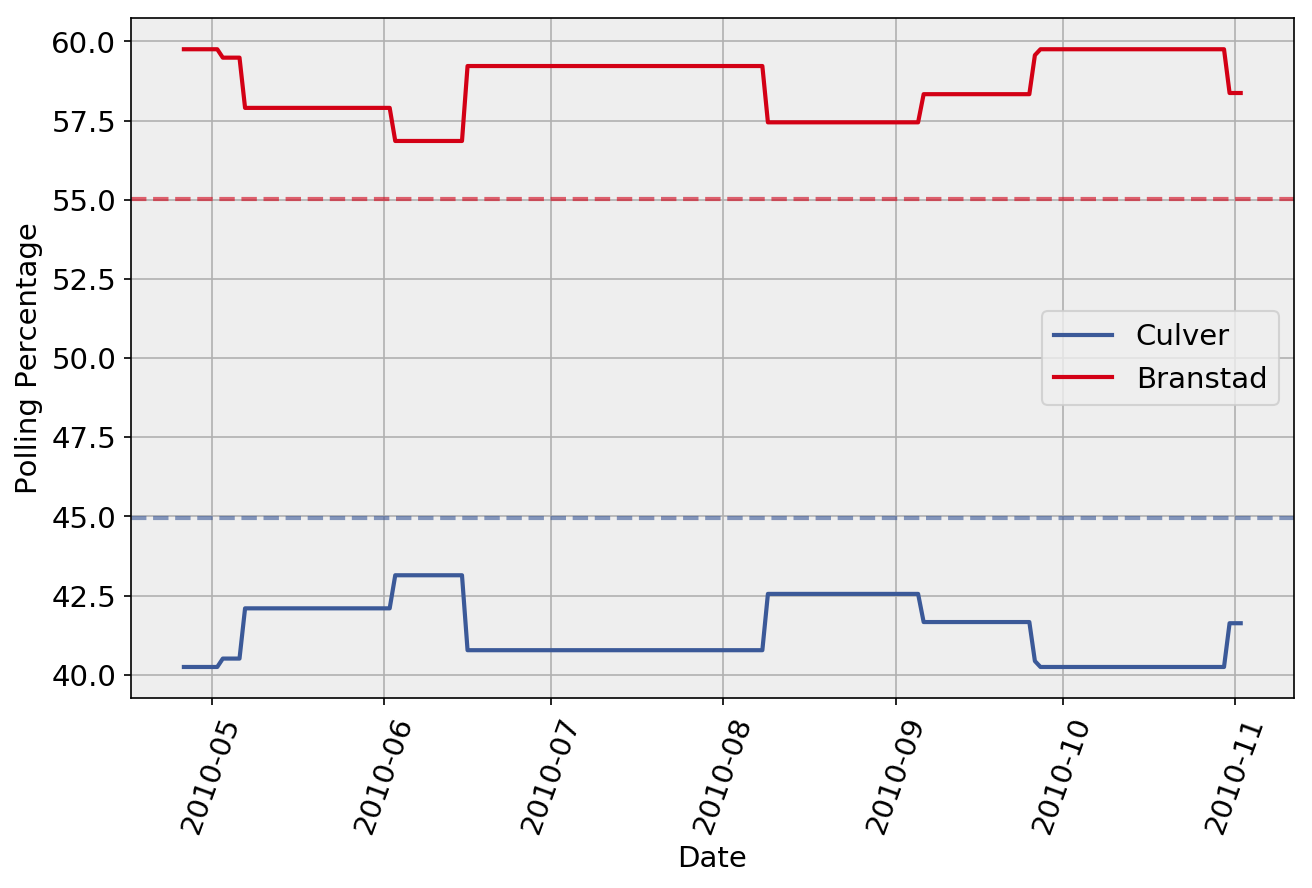

/epolls/2010/governor/me/maine_governor_lepage_vs_mitchell_vs_cutler-1231.html
{'Mitchell': '#3B5998', 'LePage': '#D30015', 'Cutler': '#000000'}
36.5
74.8
93.9


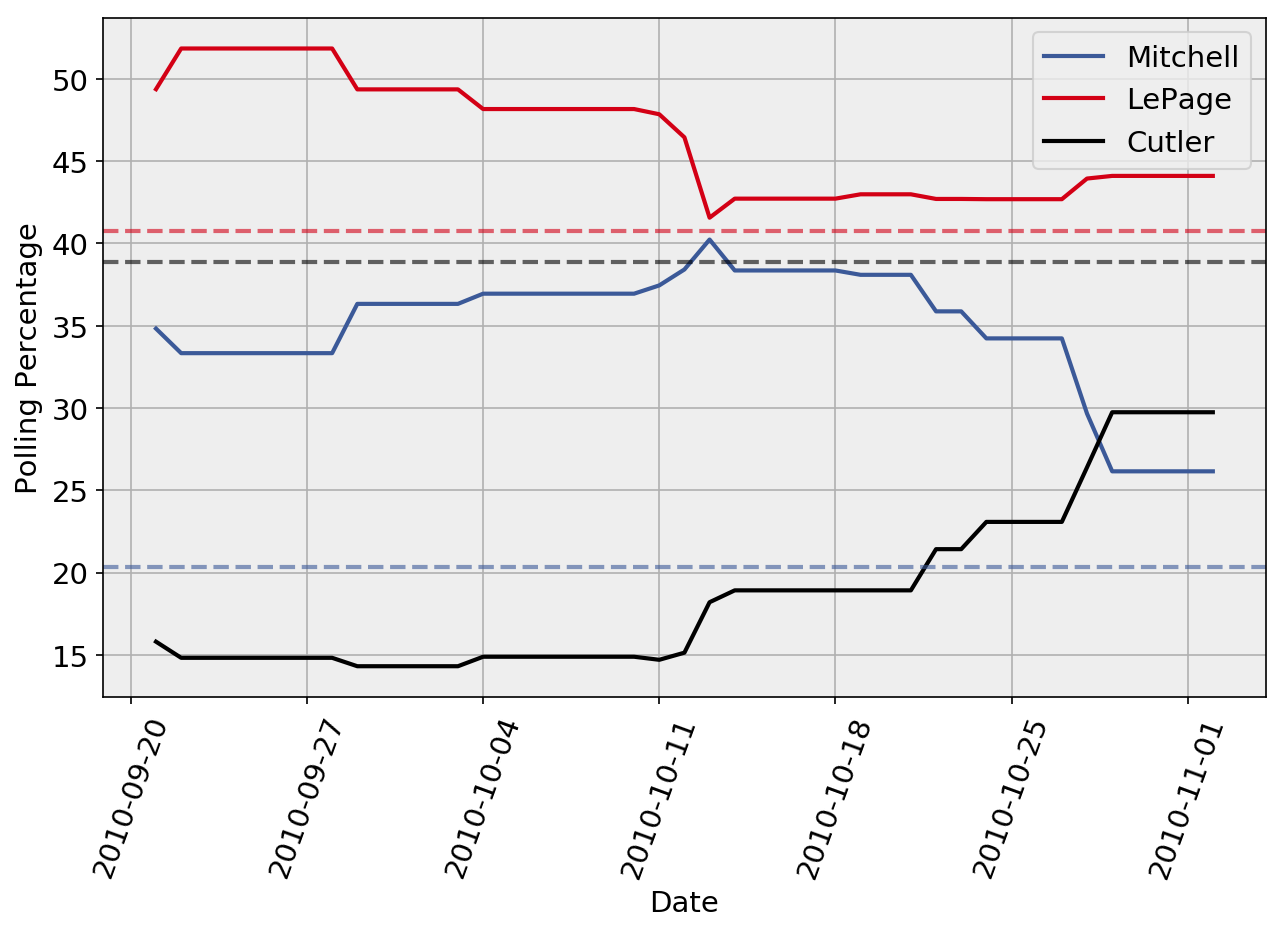

/epolls/2010/governor/mi/michigan_governor_snyder_vs_bernero-1407.html
{'Snyder': '#D30015', 'Bernero': '#3B5998'}
39.9
98.0


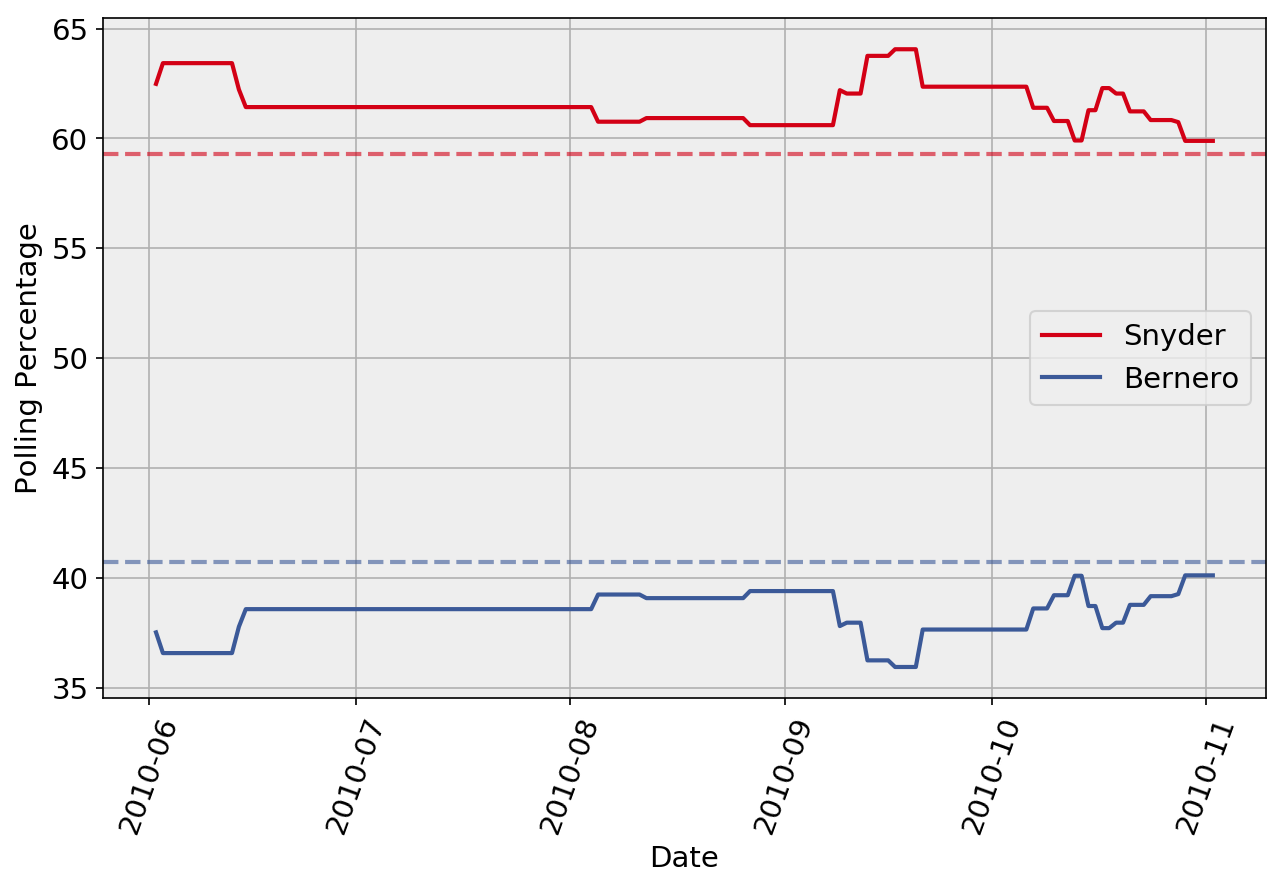

/epolls/2010/governor/nv/nevada_governor_sandoval_vs_reid-1137.html
{'Reid': '#3B5998', 'Sandoval': '#D30015'}
41.6
95.0


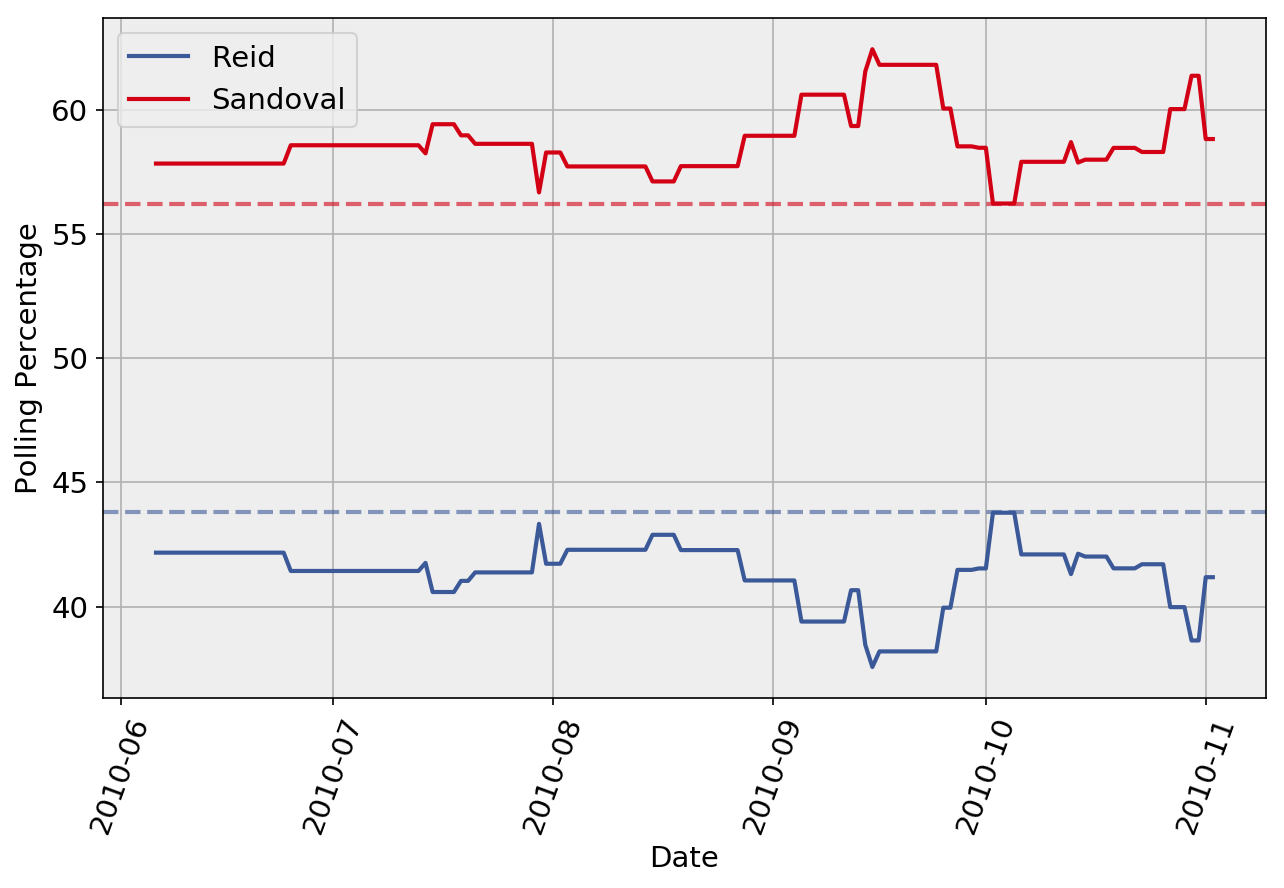

/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html
{'Brown': '#3B5998', 'Whitman': '#D30015'}
53.1
94.8


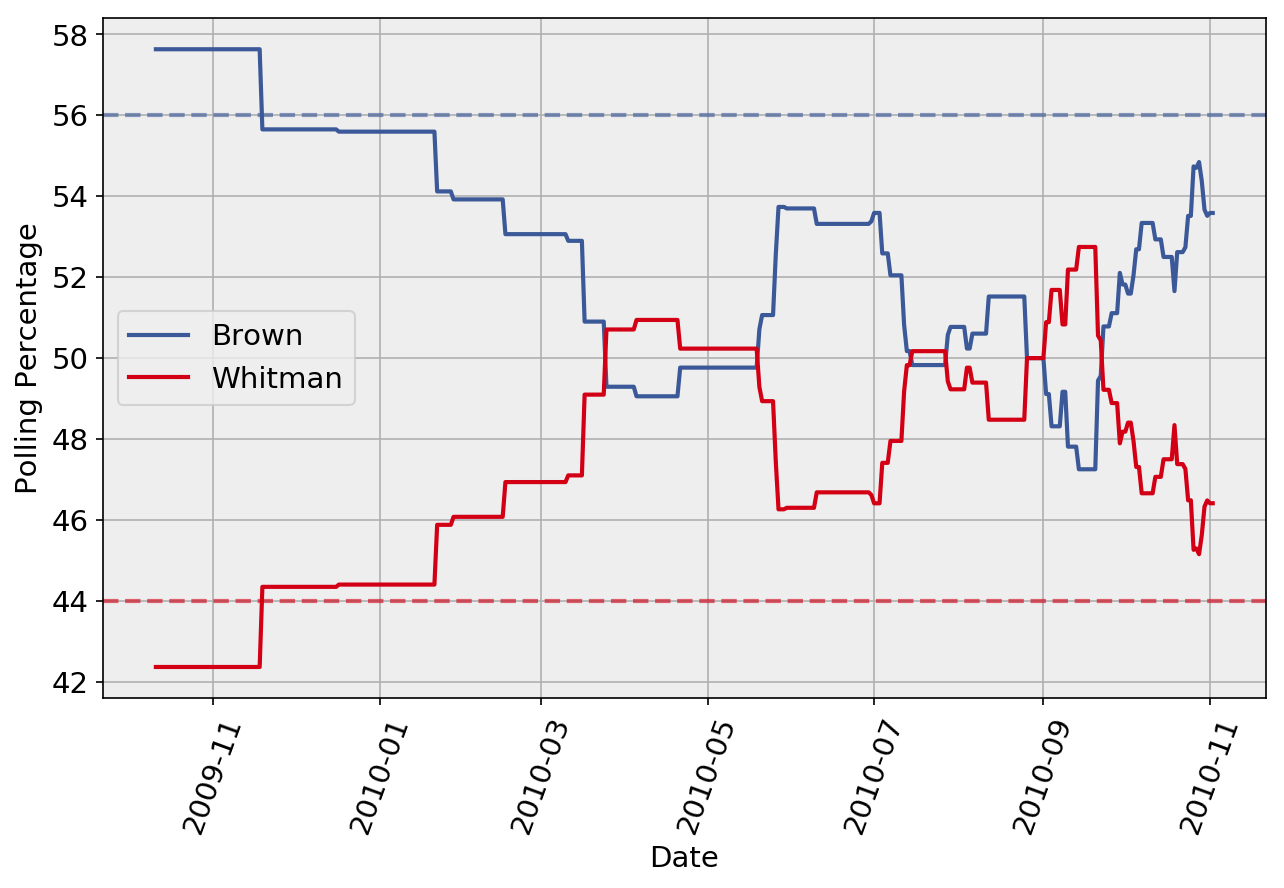

/epolls/2010/governor/nm/new_mexico_governor_martinez_vs_denish-1323.html
{'Martinez': '#D30015', 'Denish': '#3B5998'}
46.4
100.0


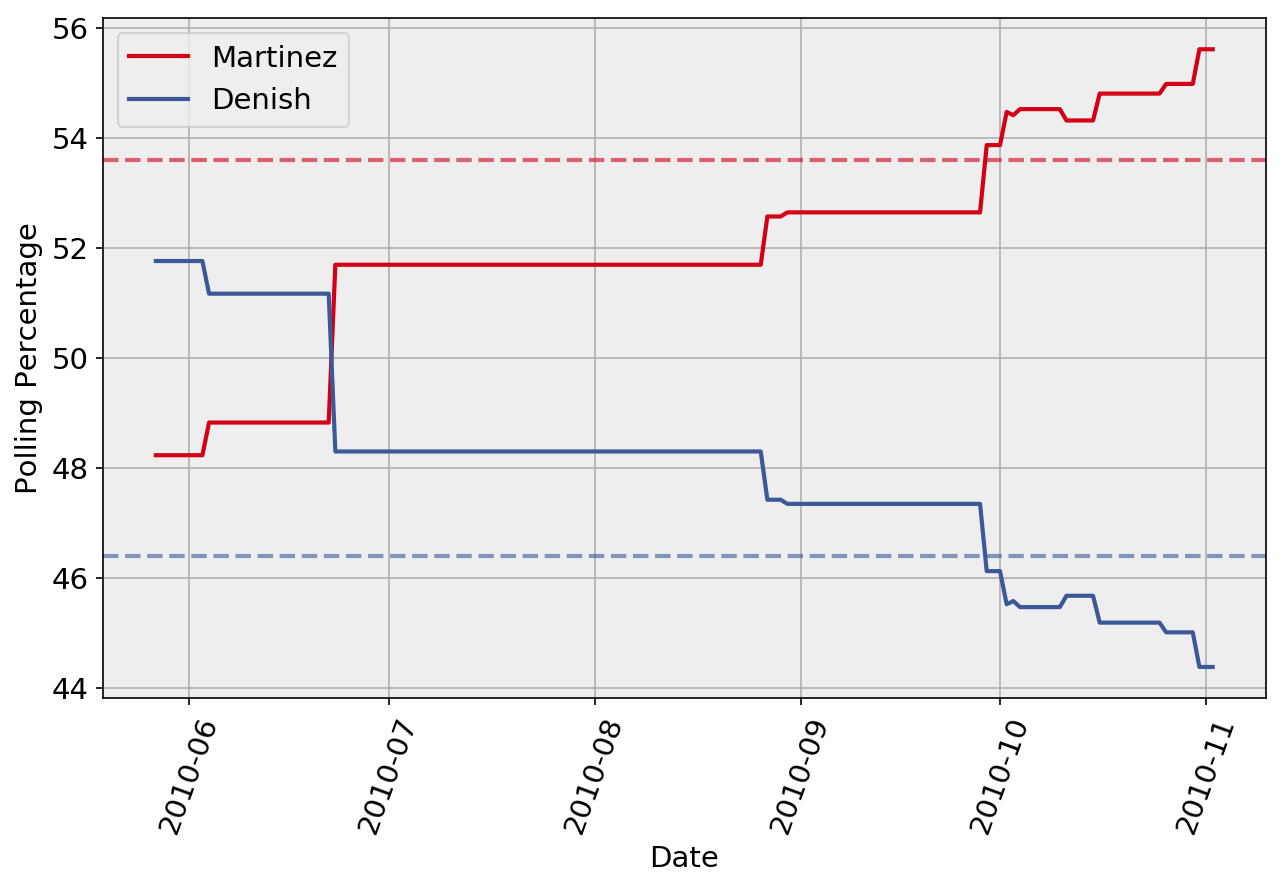

/epolls/2010/governor/pa/pennsylvania_governor_corbett_vs_onorato-1333.html
{'Corbett': '#D30015', 'Onorato': '#3B5998'}
54.5
100.0


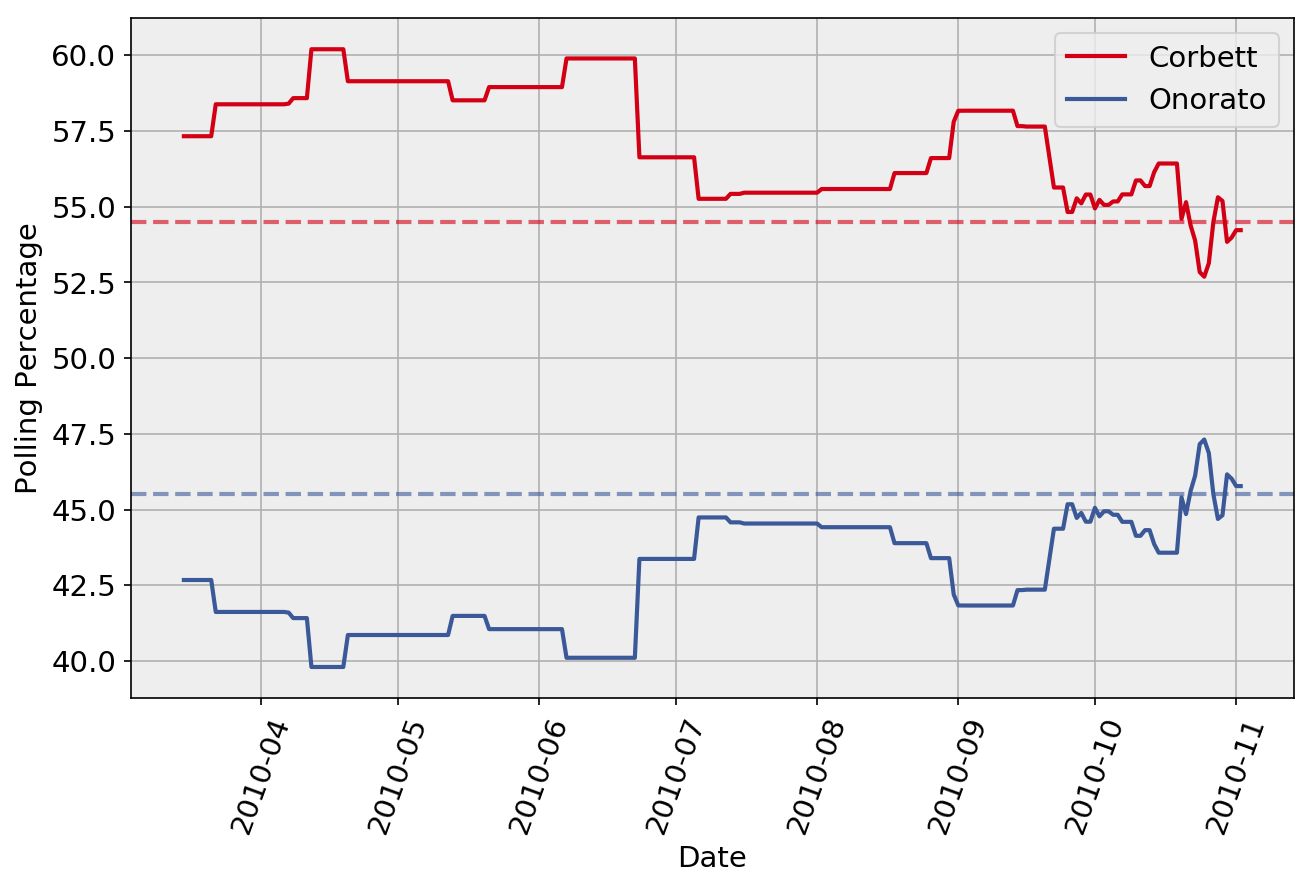

/epolls/2010/governor/wi/wisconsin_governor_walker_vs_barrett-1184.html
{'Walker': '#D30015', 'Barrett': '#3B5998'}
46.6
98.9


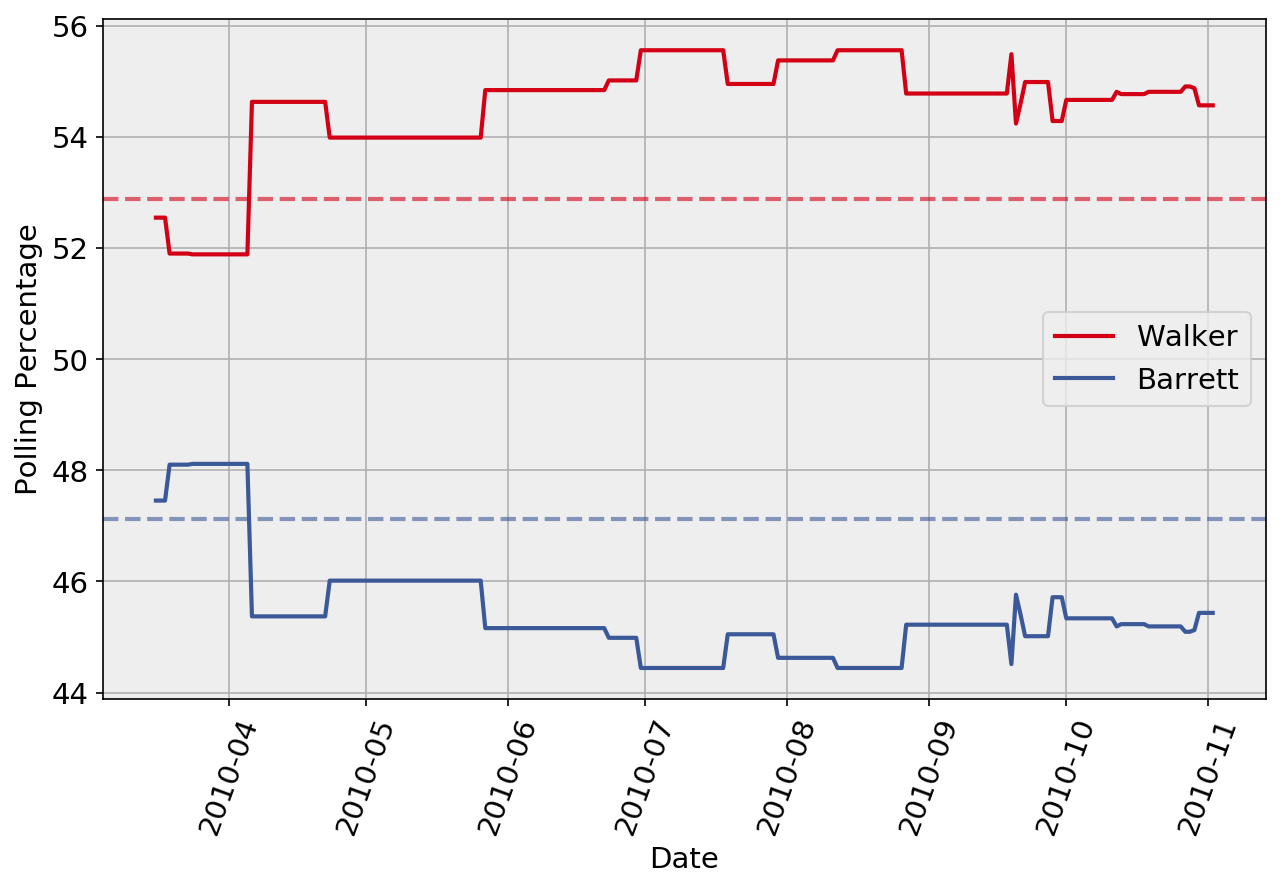

/epolls/2010/governor/ia/iowa_governor_branstad_vs_culver-1200.html
{'Culver': '#3B5998', 'Branstad': '#D30015'}
53.0
96.3


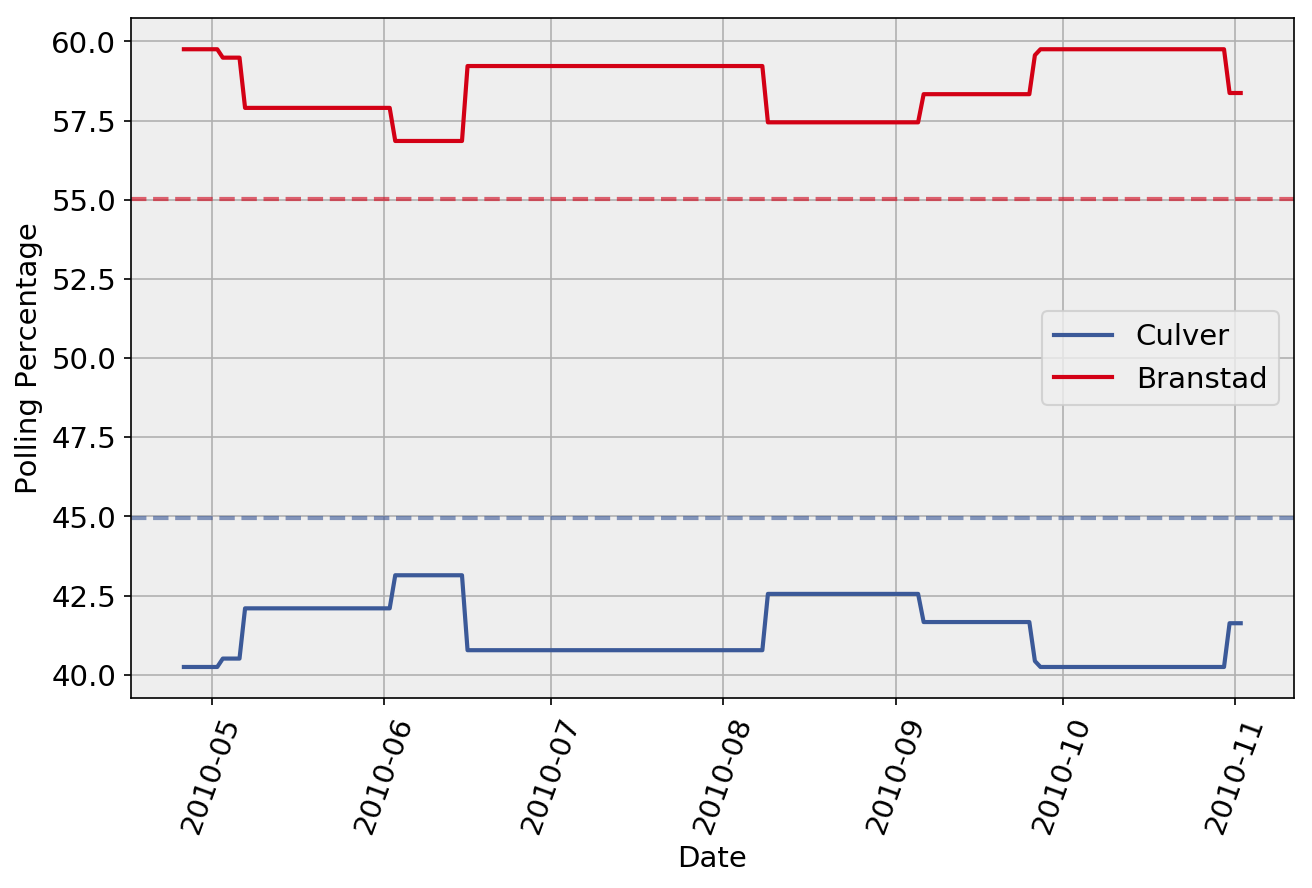

/epolls/2010/governor/me/maine_governor_lepage_vs_mitchell_vs_cutler-1231.html
{'Mitchell': '#3B5998', 'LePage': '#D30015', 'Cutler': '#000000'}
36.5
74.8
93.9


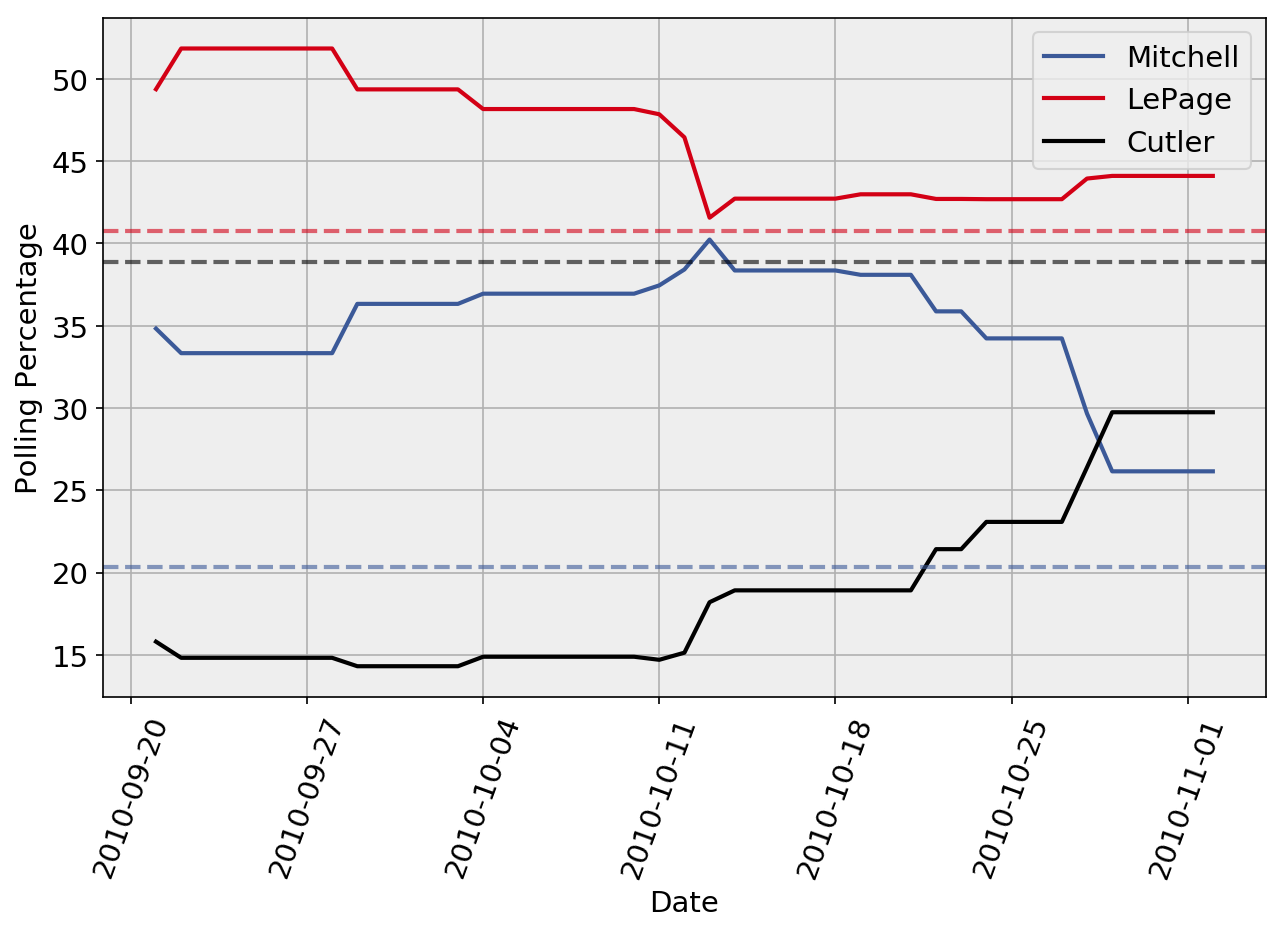

/epolls/2010/governor/mi/michigan_governor_snyder_vs_bernero-1407.html
{'Snyder': '#D30015', 'Bernero': '#3B5998'}
39.9
98.0


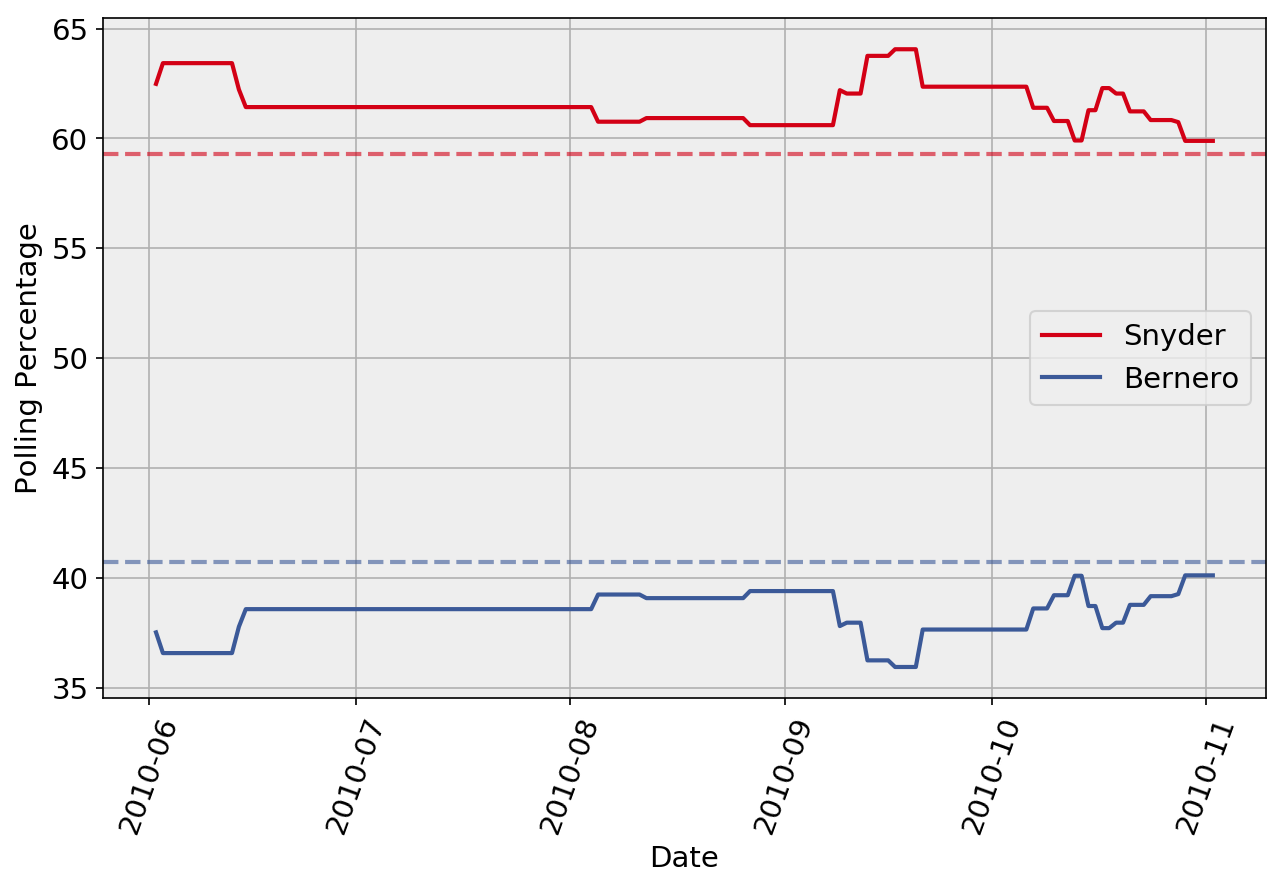

/epolls/2010/governor/ks/kansas_governor_brownback_vs_holland-1235.html


HTTPError: HTTP Error 403: Forbidden

In [284]:
i  = 1
for race in find_governor_races("http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html"):
    if i!=2:
        plot_race(race)
        plt.show()
    i+=1

In [286]:
def party_from_color(color):
    if color in ['#0000CC', '#3B5998']:
        return 'democrat'
    if color in ['#FF0000', '#D30015']:
        return 'republican'
    return 'other'

    

In [440]:
def error_data(url):
    id = id_from_url(url)
    main_url = "http://charts.realclearpolitics.com/charts/"
    bs_tree = get_poll_xml(main_url,id)
    colors = plot_colors(bs_tree)
    if len(colors) == 0:
        "here"
        return pd.DataFrame()
    poll_data_frame = rcp_poll_data(bs_tree)
    result = get_actual_election_results(url)
    
    poll_data_frame = poll_data_frame.rename(columns = {c: c.strip() for c in poll_data_frame.columns})
    for k,v in result.items():
        print k
        result[k.strip()[:-4]] = v
   # print result
    candidates = [c for c in poll_data_frame.columns if c is not 'date']
    poll_data_frame.index = poll_data_frame.date
    #print poll_data_frame
    poll_data_frame_new = poll_data_frame.resample('D').median()
   # print poll_data_frame_new
    #poll_data_frame_new = poll_data_frame.dropna()
    forecast_length = (poll_data_frame.date.max()-poll_data_frame.date).values
    forecast_length =  forecast_length/np.timedelta64(1, 'D')
    #poll_data_frame = poll_data_frame.dropna()
    
    #print poll_data_frame
    
    errors = {}
    normalized = {}
    poll_lead = {}
    for c in candidates:
        corr = poll_data_frame_new[c].values/poll_data_frame_new[candidates].sum(axis = 1).values*100.
        error = corr - result[c.strip()]
        
        normalized[c] = corr
        errors[c] = error
        
    n = forecast_length.size
    #print normalized
   # print errors
    result= {}
    result['percentage'] = np.hstack(normalized[c] for c in candidates)
    result['error'] = np.hstack(errors[c] for c in candidates)
    result['candidate'] = np.hstack(np.repeat(c, n) for c in candidates)
    result['party'] = np.hstack(np.repeat(party_from_color(colors[c.strip()]), n) for c in candidates)
    result['forecast_length'] = np.hstack(forecast_length for _ in candidates)
    
    
    result = pd.DataFrame(result)
    return result


In [409]:
error_data("/epolls/2010/governor/ar/arkansas_governor_keet_vs_beebe-1568.html")

http://charts.realclearpolitics.com/charts/1568.xml
https://www.realclearpolitics.com/epolls/2010/governor/ar/arkansas_governor_keet_vs_beebe-1568.html
64.5
98.1
Beebe (D)
Keet (R)
['Beebe', 'Keet']
  candidate     error  forecast_length     party  percentage
0     Beebe -5.639345            112.0  democrat   60.109890
1     Beebe -5.639345            111.0  democrat   60.109890
2     Beebe -8.276708            110.0  democrat   57.472527
3     Beebe -8.276708            109.0  democrat   57.472527
4     Beebe -8.276708            108.0  democrat   57.472527


In [443]:
def all_error_data():
    i  = 1
    data_frame = pd.DataFrame(columns=['candidate','error','forecast_length','party','percentage'])
    for race in find_governor_races("http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html"):
        if i!=2 and i!=6 and i!=40 and i!=48:
            data_frame = data_frame.append(error_data(race))
        i+=1
    return data_frame    

In [444]:
final_data_frame = all_error_data()

http://charts.realclearpolitics.com/charts/1568.xml
https://www.realclearpolitics.com/epolls/2010/governor/ar/arkansas_governor_keet_vs_beebe-1568.html
64.5
98.1
Beebe (D)
Keet (R)
http://charts.realclearpolitics.com/charts/1423.xml
https://www.realclearpolitics.com/epolls/2010/governor/ny/new_york_governor_paladino_vs_cuomo-1423.html
61.4
95.5
Paladino (R)
Cuomo (D)
http://charts.realclearpolitics.com/charts/1113.xml
https://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html
53.1
94.8
Brown (D)
Whitman (R)
http://charts.realclearpolitics.com/charts/1446.xml
https://www.realclearpolitics.com/epolls/2010/governor/nh/new_hampshire_governor_stephen_vs_lynch-1446.html
52.6
97.7
Lynch (D)
Stephen (R)
http://charts.realclearpolitics.com/charts/1357.xml
https://www.realclearpolitics.com/epolls/2010/governor/ct/connecticut_governor_foley_vs_malloy-1357.html
48.9
98.5
Malloy (D)
Foley (R)
http://charts.realclearpolitics.com/charts/1607.xml
https://w

http://charts.realclearpolitics.com/charts/1416.xml
http://charts.realclearpolitics.com/charts/1454.xml
http://charts.realclearpolitics.com/charts/1627.xml


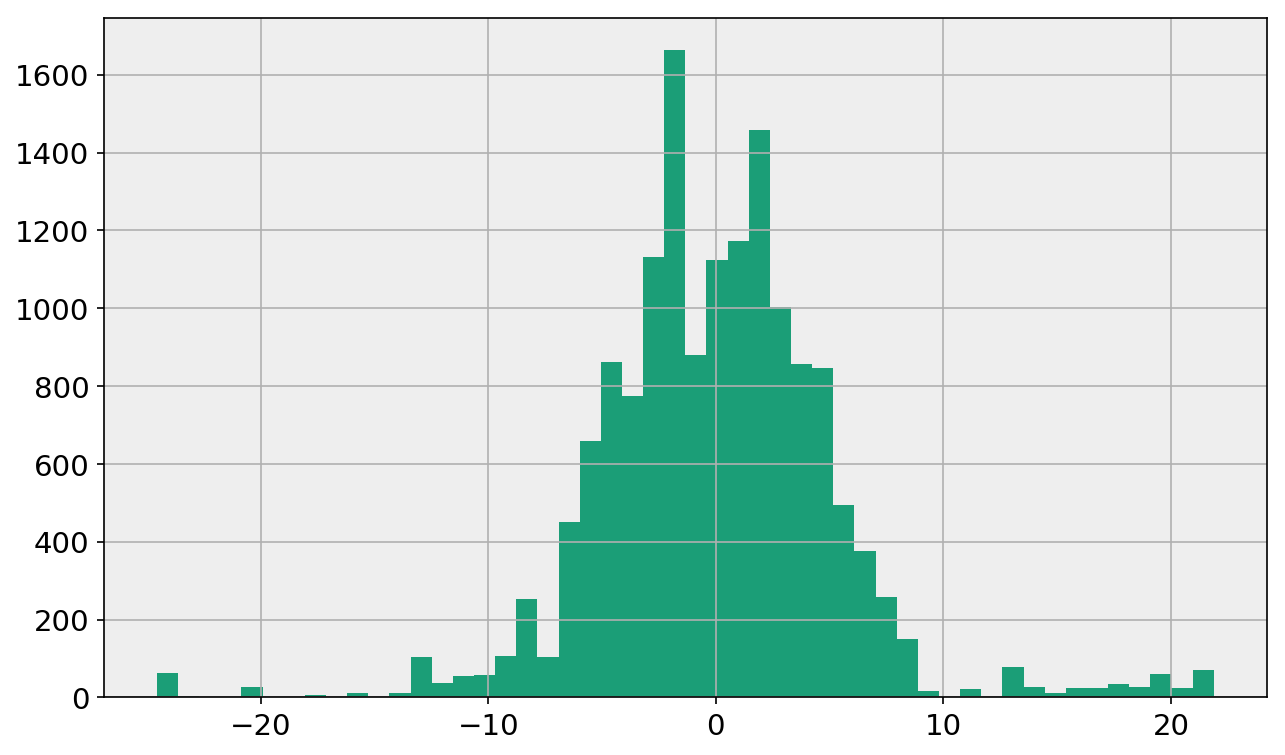

In [446]:
final_data_frame.error.hist(bins=50)

In [449]:
np.std(final_data_frame.error)

5.2843080777272045

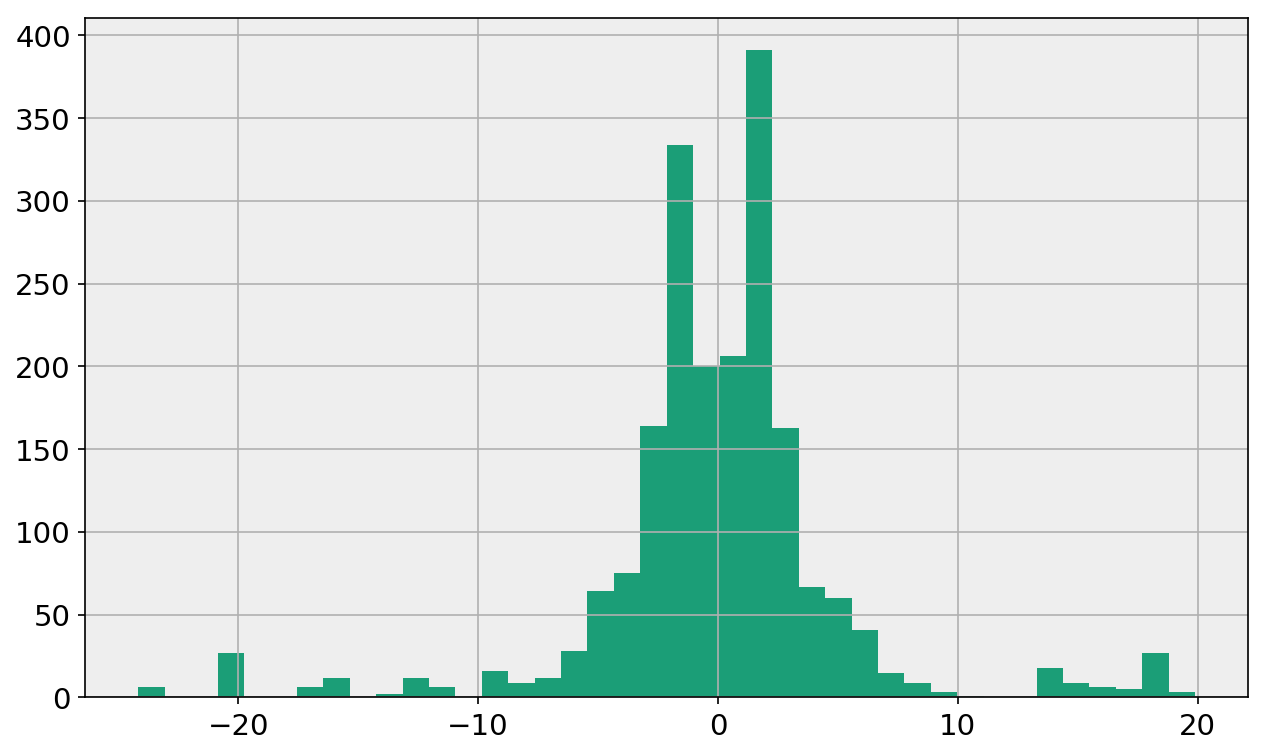

In [460]:
final_data_frame[final_data_frame['forecast_length']<30].error.hist(bins=40)

In [462]:
np.std(final_data_frame[final_data_frame['forecast_length']<15].error)

3.681417524809555

In [463]:
final_data_frame.tail()

,candidate,error,forecast_length,party,percentage
785,Whitman,NaN,4.0,republican,NaN
786,Whitman,NaN,3.0,republican,NaN
787,Whitman,NaN,2.0,republican,NaN
788,Whitman,NaN,1.0,republican,NaN
789,Whitman,NaN,0.0,republican,NaN


In [469]:
final_data_frame_without_nan = final_data_frame[~np.isnan(final_data_frame.error)]

In [473]:
pl = (final_data_frame_without_nan[final_data_frame_without_nan.forecast_length <=14].error)

In [483]:
mu,sigma = np.mean(pl),np.std(pl)

In [490]:
def draw_conclusion(candidate_one_data,candidate_two_data,final_data_frame_without_nan):
    candidate_one_data = (candidate_one_data/(candidate_one_data+candidate_two_data))*100.0
    candidate_two_data = 100.0-candidate_one_data
    p1,p2 = 0,0
    pl = (final_data_frame_without_nan[final_data_frame_without_nan.forecast_length <=14].error)
    mu,sigma = np.mean(pl),np.std(pl)
    for i in range(1000):
        erros_list =  final_data_frame_without_nan[final_data_frame_without_nan.forecast_length <=14].error
        random_error =  np.random.normal(mu,sigma)
        candidate_one_data =candidate_one_data + random_error
        candidate_two_data =candidate_two_data - random_error
        p1+=(candidate_one_data>candidate_two_data)
        p2+=(candidate_two_data>candidate_one_data)

    return p1/1000.0,p2/1000.0
        
        

In [493]:
draw_conclusion(55,31,final_data_frame_without_nan)

(0.024, 0.976)